Descriptive and Predictive Group project 

In [110]:
import sys
from scipy.stats.mstats   import winsorize
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from matplotlib           import pyplot
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [111]:
donors = pd.read_csv(r'C:\Users\jsubagiyo\Documents\Predictive Analytics\donors.csv')
gifts = pd.read_csv(r'C:\Users\jsubagiyo\Documents\Predictive Analytics\gifts.csv')
campaign_6169 = pd.read_csv(r'C:\Users\jsubagiyo\Documents\Predictive Analytics\selection campaign 6169.csv')
campaign_7244 = pd.read_csv(r'C:\Users\jsubagiyo\Documents\Predictive Analytics\selection campaign 7244.csv')
campaigns = pd.read_csv(r'C:\Users\jsubagiyo\Documents\Predictive Analytics\campaigns.csv', delimiter=';')

In [112]:
#clean gifts table
gifts.isna().sum().sum()

15637

In [113]:
gifts = gifts.fillna(0)

In [114]:
gifts.isna().sum().sum()

0

In [115]:
#change , for a . in amount 
gifts['amount'] = pd.to_numeric(gifts['amount'].str.replace(',', '.', regex=False),errors='coerce')

In [116]:
gifts['date'] = pd.to_datetime(gifts['date'],format='%d/%m/%Y', errors='coerce')

In [117]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   donorID     216594 non-null  object        
 1   campaignID  216594 non-null  float64       
 2   amount      216571 non-null  float64       
 3   date        216594 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 6.6+ MB


In [118]:
#Age
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

# (current date)
current_date = pd.to_datetime('2020-02-01')

# Calculate age
donors['Age'] = donors['dateOfBirth'].apply(lambda dob: current_date.year - dob.year - ((current_date.month, current_date.day) < (dob.month, dob.day)))

In [119]:
donors

,donorID,zipcode,province,region,gender,language,dateOfBirth,Age
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52
1,D100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,68
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,33
3,D100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,67
4,D100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,33
...,...,...,...,...,...,...,...,...
44686,D144687,4900.0,Liege,Wallonia,M,FR,1970-09-12,49
44687,D144688,3600.0,Limburg,Flanders,M,NL,1972-11-28,47
44688,D144689,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52
44689,D144690,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43


In [120]:
print(donors['Age'].nlargest(5))

27008    130
27453    127
509      100
2759     100
5713     100
Name: Age, dtype: int64


In [121]:
donors = donors[donors.index != 27008]
donors = donors[donors.index != 27453]


In [122]:
donors['gender'].value_counts()

gender
M    25791
F    18866
Name: count, dtype: int64

In [123]:
donors['region'].value_counts()

region
Flanders    40148
Wallonia     3051
Brussels     1488
Missing         2
Name: count, dtype: int64

In [124]:
donors['language'].value_counts()

language
NL    40061
FR     4622
EN        6
Name: count, dtype: int64

In [125]:
gifts['campaignID'].value_counts()

campaignID
0.0       15637
4137.0     4020
1739.0     2824
3049.0     2022
2714.0     1946
          ...  
7356.0        1
574.0         1
1153.0        1
476.0         1
6924.0        1
Name: count, Length: 368, dtype: int64

In [126]:
gifts['amount'].value_counts()

amount
30.00     35711
24.79     28344
10.00     18240
5.00      13806
12.39     11605
          ...  
33.94         1
19.31         1
6.57          1
428.50        1
183.00        1
Name: count, Length: 1155, dtype: int64

In [127]:
gifts.describe()

,campaignID,amount,date
count,216594.000000,2.165710e+05,216594
mean,2612.960525,5.751130e+01,2011-03-20 22:11:32.695088384
min,0.000000,1.000000e-01,2000-06-05 00:00:00
25%,1736.000000,1.000000e+01,2008-07-05 00:00:00
50%,2485.000000,2.479000e+01,2010-11-17 00:00:00
75%,3441.000000,3.200000e+01,2013-04-29 00:00:00
max,7536.000000,4.000000e+06,2020-01-04 00:00:00
std,1467.388602,1.011234e+04,NaN


Training Set 

In [128]:
#Train set 
trainset= pd.merge(gifts,campaign_6169, on='donorID')
trainset= pd.merge(trainset, donors, on='donorID')
trainset=pd.merge(trainset,campaigns,on='campaignID', how='left' )

In [129]:
trainset

,donorID,campaignID,amount,date_x,zipcode,province,region,gender,language,dateOfBirth,Age,date_y,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €"
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €"
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €"
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151722,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,08/06/2018,39 445,"0,30 €"
151723,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,26/04/2019,28 592,"0,06 €"
151724,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,26/11/2019,35 199,"0,36 €"
151725,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €"


In [130]:
# dates for  trainign 
campaign_date = pd.Timestamp("2018-09-04")

# (training)
#start_x_training = campaign_date - pd.DateOffset(years=3)  
end_x_training = campaign_date- pd.DateOffset(days=30) 
#print(f"x_Training: {start_x_training} to {end_x_training}")

In [131]:
x_trainset = trainset[
     (trainset['date_x'] <= end_x_training) 
]

In [132]:
#Rename columns
x_trainset = x_trainset.rename(columns={'date_x':'dateOfDonation'})
x_trainset = x_trainset.rename(columns={'date_y':'dateOfCampaign'})

x_trainset



,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,Age,dateOfCampaign,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €"
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €"
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €"
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151720,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,Wallonia,M,FR,1970-09-12,49,18/10/2015,24 753,"0,20 €"
151721,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,20/07/2005,24 950,"0,14 €"
151722,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,08/06/2018,39 445,"0,30 €"
151725,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €"


In [133]:
print(x_trainset.isnull().sum())

donorID               0
campaignID            0
amount               22
dateOfDonation        0
zipcode              12
province              0
region                0
gender              104
language              0
dateOfBirth           0
Age                   0
dateOfCampaign    10919
lettersSent       10919
CostUnit          10919
dtype: int64


In [134]:
#Frequency 

x_trainset_freq= x_trainset[x_trainset['dateOfDonation'].notnull()]

x_trainset_freq = x_trainset.groupby('donorID').size().reset_index(name='frequency')

x_trainset_freq.head()




,donorID,frequency
0,D100001,12
1,D100002,1
2,D100004,26
3,D100008,3
4,D100009,19


In [135]:
#add frequency to table 
x_trainset=pd.merge(x_trainset,x_trainset_freq,on='donorID' )

print(x_trainset['zipcode'].value_counts())



zipcode
8000.0    2859
9000.0    2797
8400.0    2373
8800.0    1911
8200.0    1905
          ... 
6210.0       1
7032.0       1
6663.0       1
6686.0       1
5537.0       1
Name: count, Length: 963, dtype: int64


In [136]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,Age,dateOfCampaign,lettersSent,CostUnit,frequency
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN,12
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €",12
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €",12
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €",12
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €",12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,Wallonia,M,FR,1970-09-12,49,18/10/2015,24 753,"0,20 €",1
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,20/07/2005,24 950,"0,14 €",2
147448,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,08/06/2018,39 445,"0,30 €",2
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €",1


In [137]:
#monetary 
monetary = x_trainset.groupby('donorID')['amount'].sum().reset_index()
monetary.rename(columns={'amount': 'monetary_value'}, inplace=True)
x_trainset = pd.merge(x_trainset, monetary, on='donorID')


In [138]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,Age,dateOfCampaign,lettersSent,CostUnit,frequency,monetary_value
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN,12,178.49
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €",12,178.49
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €",12,178.49
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €",12,178.49
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €",12,178.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,Wallonia,M,FR,1970-09-12,49,18/10/2015,24 753,"0,20 €",1,10.00
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,20/07/2005,24 950,"0,14 €",2,124.79
147448,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,52,08/06/2018,39 445,"0,30 €",2,124.79
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €",1,40.00


In [139]:
#recency 
analysis_date = pd.to_datetime('2018-08-04')

x_trainset['recency'] = (analysis_date - x_trainset['dateOfDonation']).dt.days

In [140]:
#avg donation 
x_trainset['Avg_donation']=x_trainset.groupby('donorID')['amount'].transform('mean')

In [141]:
#replace missing values in region with the mode 

gender_mode = x_trainset["region"].mode()[0]

# replace missing with mode
x_trainset['region'] = x_trainset["region"].replace('Missing', gender_mode)

print(x_trainset['region'].value_counts())

region
Flanders    140764
Wallonia      3540
Brussels      3147
Name: count, dtype: int64


In [142]:
#region dummys 
x_trainset = x_trainset.join(pd.get_dummies(x_trainset["region"], prefix = "fl_region_is", drop_first = 1))
x_trainset = x_trainset.drop(columns=["region"])

In [143]:
#replace missing values in gender with the mode 

gender_mode = x_trainset["gender"].mode()[0]

# fill in 
x_trainset["gender"].fillna(gender_mode)

0         F
1         F
2         F
3         F
4         F
         ..
147446    M
147447    M
147448    M
147449    M
147450    M
Name: gender, Length: 147451, dtype: object

In [144]:
#gender
x_trainset = x_trainset.join(pd.get_dummies(x_trainset["gender"], prefix = "fl_gender_is", drop_first = 1))
x_trainset = x_trainset.drop(columns=["gender"])


In [145]:
#lenguage 
x_trainset = x_trainset.join(pd.get_dummies(x_trainset["language"], prefix = "fl_language_is"))
x_trainset = x_trainset.drop(columns=["language"])


In [146]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,frequency,monetary_value,recency,Avg_donation,fl_region_is_Flanders,fl_region_is_Wallonia,fl_gender_is_M,fl_language_is_EN,fl_language_is_FR,fl_language_is_NL
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,52,NaN,NaN,...,12,178.49,5247,14.874167,True,False,False,False,False,True
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,52,09/10/2007,34 636,...,12,178.49,3950,14.874167,True,False,False,False,False,True
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,52,08/12/2007,34 080,...,12,178.49,3872,14.874167,True,False,False,False,False,True
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,52,25/05/2008,30 558,...,12,178.49,3703,14.874167,True,False,False,False,False,True
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,52,22/06/2008,39 664,...,12,178.49,3678,14.874167,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,49,18/10/2015,24 753,...,1,10.00,1002,10.000000,False,True,True,False,True,False
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,52,20/07/2005,24 950,...,2,124.79,4761,62.395000,True,False,True,False,False,True
147448,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,52,08/06/2018,39 445,...,2,124.79,40,62.395000,True,False,True,False,False,True
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,43,25/12/2014,37 833,...,1,40.00,1313,40.000000,True,False,True,False,True,False


In [147]:
#total donations 
donation_counts = x_trainset.groupby('donorID')['amount'].count()


x_trainset['total_donations'] = x_trainset['donorID'].map(donation_counts)


In [148]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,monetary_value,recency,Avg_donation,fl_region_is_Flanders,fl_region_is_Wallonia,fl_gender_is_M,fl_language_is_EN,fl_language_is_FR,fl_language_is_NL,total_donations
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,52,NaN,NaN,...,178.49,5247,14.874167,True,False,False,False,False,True,12
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,52,09/10/2007,34 636,...,178.49,3950,14.874167,True,False,False,False,False,True,12
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,52,08/12/2007,34 080,...,178.49,3872,14.874167,True,False,False,False,False,True,12
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,52,25/05/2008,30 558,...,178.49,3703,14.874167,True,False,False,False,False,True,12
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,52,22/06/2008,39 664,...,178.49,3678,14.874167,True,False,False,False,False,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,49,18/10/2015,24 753,...,10.00,1002,10.000000,False,True,True,False,True,False,1
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,52,20/07/2005,24 950,...,124.79,4761,62.395000,True,False,True,False,False,True,2
147448,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,52,08/06/2018,39 445,...,124.79,40,62.395000,True,False,True,False,False,True,2
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,43,25/12/2014,37 833,...,40.00,1313,40.000000,True,False,True,False,True,False,1


In [149]:
#Min and Max donation 
max_donations=x_trainset.groupby('donorID')['amount'].max()
x_trainset['max_donations'] = x_trainset['donorID'].map(max_donations)



In [150]:
#min 
min_donations=x_trainset.groupby('donorID')['amount'].min()
x_trainset['min_donations'] = x_trainset['donorID'].map(min_donations)


In [151]:
#Age
x_trainset['dateOfBirth'] = pd.to_datetime(x_trainset['dateOfBirth'])

# (current date)
current_date = pd.to_datetime('2018-08-04')

# Calculate age
x_trainset['Age'] = x_trainset['dateOfBirth'].apply(lambda dob: current_date.year - dob.year - ((current_date.month, current_date.day) < (dob.month, dob.day)))

In [152]:
#day of donation vs day of campaing 
x_trainset['dateOfCampaign']=pd.to_datetime(x_trainset['dateOfCampaign'],format='%d/%m/%Y', errors='coerce')

In [153]:
#calculate the days between the campign and the day of the donation 
x_trainset['DaysDiff'] = (x_trainset['dateOfDonation'] - x_trainset['dateOfCampaign']).dt.days

In [154]:
#avg of daysdiff

avg_daysdiff = x_trainset.groupby('donorID')['DaysDiff'].mean()

x_trainset['avg_daysdiff'] = x_trainset['donorID'].map(round(avg_daysdiff, 2))

In [155]:
# Calculate time difference (in days) between consecutive donations for each DonorID
x_trainset['TimeDiff'] = x_trainset.groupby('donorID')['dateOfDonation'].diff().dt.days


In [156]:
#avg of timediff

avg_timediff = x_trainset.groupby('donorID')['TimeDiff'].mean()

x_trainset['avg_timediff'] = x_trainset['donorID'].map(avg_timediff)

In [157]:
global_median_timediff = x_trainset['TimeDiff'].median()

x_trainset['avg_timediff'] = x_trainset['avg_timediff'].fillna(global_median_timediff)

In [158]:
#Interaction Effect Variable between age and gender

x_trainset['age_fl_gender_is'] = x_trainset['Age'] * x_trainset['fl_gender_is_M']

In [159]:
#Interaction Effect between age and region

x_trainset['age_fl_region_is_Flanders'] = x_trainset['Age'] * x_trainset['fl_region_is_Flanders']
x_trainset['age_fl_region_is_Wallonia'] = x_trainset['Age'] * x_trainset['fl_region_is_Wallonia']
#no more other regions?

In [160]:
#Interaction Effect between age and language

x_trainset['age_fl_language_is_FR'] = x_trainset['Age'] * x_trainset['fl_language_is_FR']
x_trainset['age_fl_language_is_NL'] = x_trainset['Age'] * x_trainset['fl_language_is_NL']

In [161]:
#Interaction Effect between Gender and Region

x_trainset['gender_fl_region_is_Flanders'] = x_trainset['fl_gender_is_M'] * x_trainset['fl_region_is_Flanders']
x_trainset['gender_fl_region_is_Wallonia'] = x_trainset['fl_gender_is_M'] * x_trainset['fl_region_is_Wallonia']

In [162]:
#Interaction Effect between Gender and Language

x_trainset['gender_fl_language_is_FR'] = x_trainset['fl_gender_is_M'] * x_trainset['fl_language_is_FR']
x_trainset['gender_fl_language_is_NL'] = x_trainset['fl_gender_is_M'] * x_trainset['fl_language_is_NL']

In [163]:
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
x_trainset['age_group'] = pd.cut(x_trainset['Age'], bins=bins, labels=labels)
x_trainset = pd.get_dummies(x_trainset, columns=['age_group'], prefix=['age_group'])

In [164]:
lifespan = x_trainset.groupby('donorID')['dateOfDonation'].agg(['min', 'max'])
x_trainset['lifespan_days'] = x_trainset['donorID'].map(
    (lifespan['max'] - lifespan['min']).dt.days
)

In [165]:
x_trainset['donation_rank'] = x_trainset.groupby('donorID')['dateOfDonation'].rank()
early_avg = (
    x_trainset[x_trainset['donation_rank'] <= 3]
    .groupby('donorID')['amount']
    .mean()
)
recent_avg = (
    x_trainset[x_trainset['donation_rank'] > (x_trainset['donation_rank'].max() - 3)]
    .groupby('donorID')['amount']
    .mean()
)
x_trainset['donation_trend'] = x_trainset['donorID'].map(
    recent_avg / early_avg
)

In [166]:
donation_variability = x_trainset.groupby('donorID')['amount'].std()
x_trainset['donation_variability'] = x_trainset['donorID'].map(donation_variability)

In [167]:
x_trainset['days_between'] = x_trainset.groupby('donorID')['dateOfDonation'].diff().dt.days
donation_density = x_trainset.groupby('donorID')['days_between'].mean()
x_trainset['donation_density'] = x_trainset['donorID'].map(donation_density)

In [168]:
campaign_engagement = x_trainset.groupby('donorID')['campaignID'].nunique()
x_trainset['campaign_engagement'] = x_trainset['donorID'].map(campaign_engagement)


In [169]:
recent_donations = x_trainset[x_trainset['dateOfDonation'] >= (end_x_training - pd.DateOffset(years=1))]
recent_ratio = recent_donations.groupby('donorID')['amount'].count() / x_trainset.groupby('donorID')['amount'].count()
x_trainset['recent_donations_ratio'] = x_trainset['donorID'].map(recent_ratio)

In [170]:
max_donation = x_trainset.groupby('donorID')['amount'].max()
x_trainset['max_donation'] = x_trainset['donorID'].map(max_donation)

In [171]:
donor_loyalty = x_trainset.groupby('donorID')['campaignID'].nunique() / x_trainset['campaignID'].nunique()
x_trainset['donor_loyalty'] = x_trainset['donorID'].map(donor_loyalty)

In [172]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,NaT,NaN,...,2838,1.0,NaN,7.870151,NaN,258.0,12,NaN,30.0,0.036585
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,50,2007-10-09,34 636,...,2838,2.0,NaN,7.870151,1297.0,258.0,12,NaN,30.0,0.036585
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,50,2007-12-08,34 080,...,2838,3.0,NaN,7.870151,78.0,258.0,12,NaN,30.0,0.036585
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,50,2008-05-25,30 558,...,2838,4.0,NaN,7.870151,169.0,258.0,12,NaN,30.0,0.036585
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,50,2008-06-22,39 664,...,2838,5.0,NaN,7.870151,25.0,258.0,12,NaN,30.0,0.036585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,47,2015-10-18,24 753,...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,10.0,0.003049
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,51,2005-07-20,24 950,...,4721,1.0,NaN,53.181501,NaN,4721.0,2,0.5,100.0,0.006098
147448,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,51,2018-06-08,39 445,...,4721,2.0,NaN,53.181501,4721.0,4721.0,2,0.5,100.0,0.006098
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25,37 833,...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,40.0,0.003049


In [173]:
x_trainset.fillna(0, inplace=True)

C:\Users\jsubagiyo\AppData\Local\Temp\ipykernel_9360\1708486850.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  x_trainset.fillna(0, inplace=True)


In [174]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,2838,1.0,0.0,7.870151,0.0,258.0,12,0.0,30.0,0.036585
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,50,2007-10-09 00:00:00,34 636,...,2838,2.0,0.0,7.870151,1297.0,258.0,12,0.0,30.0,0.036585
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,50,2007-12-08 00:00:00,34 080,...,2838,3.0,0.0,7.870151,78.0,258.0,12,0.0,30.0,0.036585
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,50,2008-05-25 00:00:00,30 558,...,2838,4.0,0.0,7.870151,169.0,258.0,12,0.0,30.0,0.036585
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,50,2008-06-22 00:00:00,39 664,...,2838,5.0,0.0,7.870151,25.0,258.0,12,0.0,30.0,0.036585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,47,2015-10-18 00:00:00,24 753,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,10.0,0.003049
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,51,2005-07-20 00:00:00,24 950,...,4721,1.0,0.0,53.181501,0.0,4721.0,2,0.5,100.0,0.006098
147448,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,51,2018-06-08 00:00:00,39 445,...,4721,2.0,0.0,53.181501,4721.0,4721.0,2,0.5,100.0,0.006098
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.003049


In [175]:
x_trainset=x_trainset.sort_values(by=['donorID'],ascending=[True])

x_trainset=x_trainset.drop_duplicates(subset= 'donorID', keep='first')

In [176]:
x_trainset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,2838,1.0,0.0,7.870151,0.0,258.00,12,0.0,30.00,0.036585
12,D100002,3941.0,20.00,2015-01-10,2260.0,Antwerp,1952-01-14,66,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.00,1,0.0,20.00,0.003049
37,D100004,2653.0,30.00,2011-02-05,1020.0,Brussels,1952-03-29,66,2011-02-02 00:00:00,25 277,...,2162,25.0,0.0,5.142858,127.0,86.48,26,0.0,49.58,0.079268
41,D100008,2963.0,50.00,2011-10-28,1780.0,Flemish Brabant,1937-08-30,80,2011-10-14 00:00:00,33 877,...,1590,3.0,0.0,14.435284,1447.0,795.00,3,0.0,50.00,0.009146
59,D100009,3033.0,20.00,2011-12-21,1020.0,Brussels,1932-01-20,86,2011-12-09 00:00:00,18 667,...,2259,18.0,0.0,5.682107,114.0,125.50,19,0.0,25.00,0.057927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147445,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24 00:00:00,18 803,...,0,1.0,0.0,0.000000,0.0,0.00,1,0.0,50.00,0.003049
147446,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,47,2015-10-18 00:00:00,24 753,...,0,1.0,0.0,0.000000,0.0,0.00,1,0.0,10.00,0.003049
147447,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,51,2005-07-20 00:00:00,24 950,...,4721,1.0,0.0,53.181501,0.0,4721.00,2,0.5,100.00,0.006098
147449,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.00,1,0.0,40.00,0.003049


TimeFrame

In [177]:

#  y_Training 
start_y_training = campaign_date + pd.Timedelta(days=1)  
end_y_training = campaign_date + pd.Timedelta(days=30) 

print(f"y_Training: {start_y_training} to {end_y_training}")

y_Training: 2018-09-05 00:00:00 to 2018-10-04 00:00:00


Target for training 

In [178]:
y_trainset=pd.merge(gifts, campaign_6169, on='donorID')

In [179]:

y_trainset = y_trainset[
    (y_trainset['date'] >= start_y_training) &  
    (y_trainset['date'] <= end_y_training) 
]



In [180]:
y_trainset

,donorID,campaignID,amount,date
87,D100023,6169.0,15.0,2018-09-15
227,D100034,6170.0,45.0,2018-09-19
542,D100126,6169.0,123.0,2018-09-11
797,D100253,6169.0,120.0,2018-09-18
949,D100279,6169.0,75.0,2018-09-13
...,...,...,...,...
151742,D265584,6169.0,300.0,2018-09-23
151743,D281770,6169.0,30.0,2018-09-08
151744,D317880,6169.0,157.5,2018-09-12
151745,D480980,6169.0,36.0,2018-09-12


In [181]:
y_trainset = y_trainset.groupby('donorID')['amount'].sum().reset_index()

y_trainset

,donorID,amount
0,D100023,15.0
1,D100034,45.0
2,D100126,123.0
3,D100253,120.0
4,D100279,75.0
...,...,...
1272,D263382,60.0
1273,D265584,300.0
1274,D281770,30.0
1275,D317880,157.5


In [182]:
y_trainset['target'] = (y_trainset['amount'] >= 10).astype(int)
y_trainset

,donorID,amount,target
0,D100023,15.0,1
1,D100034,45.0,1
2,D100126,123.0,1
3,D100253,120.0,1
4,D100279,75.0,1
...,...,...,...
1272,D263382,60.0,1
1273,D265584,300.0,1
1274,D281770,30.0,1
1275,D317880,157.5,1


In [183]:
#final basetable for training with features and target 

trainset=pd.merge(x_trainset,y_trainset,on='donorID', how='left' )

In [184]:
trainset

,donorID,campaignID,amount_x,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty,amount_y,target
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,0.0,7.870151,0.0,258.00,12,0.0,30.00,0.036585,NaN,NaN
1,D100002,3941.0,20.00,2015-01-10,2260.0,Antwerp,1952-01-14,66,2014-12-25 00:00:00,37 833,...,0.0,0.000000,0.0,0.00,1,0.0,20.00,0.003049,NaN,NaN
2,D100004,2653.0,30.00,2011-02-05,1020.0,Brussels,1952-03-29,66,2011-02-02 00:00:00,25 277,...,0.0,5.142858,127.0,86.48,26,0.0,49.58,0.079268,NaN,NaN
3,D100008,2963.0,50.00,2011-10-28,1780.0,Flemish Brabant,1937-08-30,80,2011-10-14 00:00:00,33 877,...,0.0,14.435284,1447.0,795.00,3,0.0,50.00,0.009146,NaN,NaN
4,D100009,3033.0,20.00,2011-12-21,1020.0,Brussels,1932-01-20,86,2011-12-09 00:00:00,18 667,...,0.0,5.682107,114.0,125.50,19,0.0,25.00,0.057927,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24 00:00:00,18 803,...,0.0,0.000000,0.0,0.00,1,0.0,50.00,0.003049,NaN,NaN
34864,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,47,2015-10-18 00:00:00,24 753,...,0.0,0.000000,0.0,0.00,1,0.0,10.00,0.003049,NaN,NaN
34865,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,51,2005-07-20 00:00:00,24 950,...,0.0,53.181501,0.0,4721.00,2,0.5,100.00,0.006098,NaN,NaN
34866,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,0.0,0.000000,0.0,0.00,1,0.0,40.00,0.003049,NaN,NaN


In [185]:
trainset['target'].value_counts(dropna=False)

target
NaN    33605
1.0     1192
0.0       71
Name: count, dtype: int64

In [186]:
trainset = trainset.drop(columns=[ 'amount_y'])

In [187]:
trainset

,donorID,campaignID,amount_x,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty,target
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,1.0,0.0,7.870151,0.0,258.00,12,0.0,30.00,0.036585,NaN
1,D100002,3941.0,20.00,2015-01-10,2260.0,Antwerp,1952-01-14,66,2014-12-25 00:00:00,37 833,...,1.0,0.0,0.000000,0.0,0.00,1,0.0,20.00,0.003049,NaN
2,D100004,2653.0,30.00,2011-02-05,1020.0,Brussels,1952-03-29,66,2011-02-02 00:00:00,25 277,...,25.0,0.0,5.142858,127.0,86.48,26,0.0,49.58,0.079268,NaN
3,D100008,2963.0,50.00,2011-10-28,1780.0,Flemish Brabant,1937-08-30,80,2011-10-14 00:00:00,33 877,...,3.0,0.0,14.435284,1447.0,795.00,3,0.0,50.00,0.009146,NaN
4,D100009,3033.0,20.00,2011-12-21,1020.0,Brussels,1932-01-20,86,2011-12-09 00:00:00,18 667,...,18.0,0.0,5.682107,114.0,125.50,19,0.0,25.00,0.057927,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24 00:00:00,18 803,...,1.0,0.0,0.000000,0.0,0.00,1,0.0,50.00,0.003049,NaN
34864,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,47,2015-10-18 00:00:00,24 753,...,1.0,0.0,0.000000,0.0,0.00,1,0.0,10.00,0.003049,NaN
34865,D144689,767.0,24.79,2005-07-22,3061.0,Flemish Brabant,1967-04-21,51,2005-07-20 00:00:00,24 950,...,1.0,0.0,53.181501,0.0,4721.00,2,0.5,100.00,0.006098,NaN
34866,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,1.0,0.0,0.000000,0.0,0.00,1,0.0,40.00,0.003049,NaN


In [188]:
trainset = trainset.drop(columns=['dateOfDonation','zipcode','province','dateOfBirth','dateOfCampaign','lettersSent','CostUnit','TimeDiff','avg_daysdiff','DaysDiff'])

In [189]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   donorID                       34868 non-null  object 
 1   campaignID                    34868 non-null  float64
 2   amount_x                      34868 non-null  float64
 3   Age                           34868 non-null  int64  
 4   frequency                     34868 non-null  int64  
 5   monetary_value                34868 non-null  float64
 6   recency                       34868 non-null  int64  
 7   Avg_donation                  34868 non-null  float64
 8   fl_region_is_Flanders         34868 non-null  bool   
 9   fl_region_is_Wallonia         34868 non-null  bool   
 10  fl_gender_is_M                34868 non-null  bool   
 11  fl_language_is_EN             34868 non-null  bool   
 12  fl_language_is_FR             34868 non-null  bool   
 13  f

In [190]:
trainset.shape

(34868, 43)

In [191]:
trainset = trainset.fillna(0)

In [192]:
trainset['target'].value_counts(dropna=False)

target
0.0    33676
1.0     1192
Name: count, dtype: int64

TEST SET

In [193]:
testset= pd.merge(gifts,campaign_7244, on='donorID')
testset= pd.merge(testset, donors, on='donorID')
testset=pd.merge(testset,campaigns,on='campaignID', how='left')


In [194]:
testset

,donorID,campaignID,amount,date_x,zipcode,province,region,gender,language,dateOfBirth,Age,date_y,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €"
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €"
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €"
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109643,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,Flanders,M,FR,1982-08-29,37,28/07/2016,57 127,"0,26 €"
109644,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,Flanders,NaN,NL,1985-06-15,34,NaN,NaN,NaN
109645,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,Flanders,F,NL,1964-09-28,55,24/04/2015,18 803,"0,32 €"
109646,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €"


In [195]:
# dates for  test
campaign_date = pd.Timestamp("2019-06-18")

# (test)
start_x_test = campaign_date - pd.DateOffset(years=3)  
end_x_test = campaign_date- pd.DateOffset(days=30) 
print(f"x_Training: {start_x_test} to {end_x_test}")

x_Training: 2016-06-18 00:00:00 to 2019-05-19 00:00:00


In [196]:
x_testset = testset[
    (testset['date_x'] <= end_x_test) 
]

In [197]:
#Rename columns
x_testset = x_testset.rename(columns={'date_x':'dateOfDonation'})
x_testset = x_testset.rename(columns={'date_y':'dateOfCampaign'})

In [198]:
x_testset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,Age,dateOfCampaign,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €"
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €"
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €"
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109643,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,Flanders,M,FR,1982-08-29,37,28/07/2016,57 127,"0,26 €"
109644,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,Flanders,NaN,NL,1985-06-15,34,NaN,NaN,NaN
109645,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,Flanders,F,NL,1964-09-28,55,24/04/2015,18 803,"0,32 €"
109646,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €"


In [199]:
print(x_testset.isnull().sum())

donorID              0
campaignID           0
amount               9
dateOfDonation       0
zipcode              3
province             0
region               0
gender              43
language             0
dateOfBirth          0
Age                  0
dateOfCampaign    8006
lettersSent       8006
CostUnit          8006
dtype: int64


In [200]:
#Frequency 

x_testset_freq= x_testset[x_testset['dateOfDonation'].notnull()]

x_testset_freq = x_testset.groupby('donorID').size().reset_index(name='frequency')

x_testset_freq.head()

,donorID,frequency
0,D100001,12
1,D100002,1
2,D100008,3
3,D100009,19
4,D100010,1


In [201]:
#add frequency to table 
x_testset=pd.merge(x_testset,x_testset_freq,on='donorID' )

In [202]:
#monetary 
monetary = x_testset.groupby('donorID')['amount'].sum().reset_index()
monetary.rename(columns={'amount': 'monetary_value'}, inplace=True)
x_testset = pd.merge(x_testset, monetary, on='donorID')

In [203]:
x_testset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,Age,dateOfCampaign,lettersSent,CostUnit,frequency,monetary_value
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,NaN,NaN,NaN,12,178.49
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,09/10/2007,34 636,"0,31 €",12,178.49
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,08/12/2007,34 080,"0,21 €",12,178.49
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,25/05/2008,30 558,"0,41 €",12,178.49
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,52,22/06/2008,39 664,"0,61 €",12,178.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108970,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,Flanders,M,FR,1982-08-29,37,28/07/2016,57 127,"0,26 €",1,40.00
108971,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,Flanders,NaN,NL,1985-06-15,34,NaN,NaN,NaN,1,50.00
108972,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,Flanders,F,NL,1964-09-28,55,24/04/2015,18 803,"0,32 €",1,50.00
108973,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,43,25/12/2014,37 833,"0,50 €",1,40.00


In [204]:
#recency 
analysis_date = pd.to_datetime('2019-06-18')

x_testset['recency'] = (analysis_date - x_testset['dateOfDonation']).dt.days

In [205]:
#avg donation 
x_testset['Avg_donation']=x_testset.groupby('donorID')['amount'].transform('mean')

In [206]:
#replace missing values in region with the mode 

gender_mode = x_testset["region"].mode()[0]

# fill in missing with mode
x_testset['region'] = x_testset["region"].replace('Missing', gender_mode)

print(x_testset['region'].value_counts())

region
Flanders    104081
Wallonia      2743
Brussels      2151
Name: count, dtype: int64


In [207]:
#region dummys 
x_testset = x_testset.join(pd.get_dummies(x_testset["region"], prefix = "fl_region_is", drop_first = 1))
x_testset = x_testset.drop(columns=["region"])

In [208]:
#replace missing values in gender with the mode 

gender_mode = x_testset["gender"].mode()[0]

# fill in with mode
x_testset["gender"].fillna(gender_mode)

0         F
1         F
2         F
3         F
4         F
         ..
108970    M
108971    M
108972    F
108973    M
108974    M
Name: gender, Length: 108975, dtype: object

In [209]:
#gender
x_testset = x_testset.join(pd.get_dummies(x_testset["gender"], prefix = "fl_gender_is", drop_first = 1))
x_testset = x_testset.drop(columns=["gender"])

In [210]:
#lenguage 
x_testset = x_testset.join(pd.get_dummies(x_testset["language"], prefix = "fl_language_is"))
x_testset = x_testset.drop(columns=["language"])

In [211]:
x_testset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,frequency,monetary_value,recency,Avg_donation,fl_region_is_Flanders,fl_region_is_Wallonia,fl_gender_is_M,fl_language_is_EN,fl_language_is_FR,fl_language_is_NL
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,52,NaN,NaN,...,12,178.49,5565,14.874167,True,False,False,False,False,True
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,52,09/10/2007,34 636,...,12,178.49,4268,14.874167,True,False,False,False,False,True
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,52,08/12/2007,34 080,...,12,178.49,4190,14.874167,True,False,False,False,False,True
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,52,25/05/2008,30 558,...,12,178.49,4021,14.874167,True,False,False,False,False,True
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,52,22/06/2008,39 664,...,12,178.49,3996,14.874167,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108970,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,1982-08-29,37,28/07/2016,57 127,...,1,40.00,1042,40.000000,True,False,True,False,True,False
108971,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,1985-06-15,34,NaN,NaN,...,1,50.00,1346,50.000000,True,False,False,False,False,True
108972,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,55,24/04/2015,18 803,...,1,50.00,1512,50.000000,True,False,False,False,False,True
108973,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,43,25/12/2014,37 833,...,1,40.00,1631,40.000000,True,False,True,False,True,False


In [212]:
#total donations 
donation_counts = x_testset.groupby('donorID')['amount'].count()


x_testset['total_donations'] = x_testset['donorID'].map(donation_counts)

In [213]:
#Min and Max donation 
max_donations=x_testset.groupby('donorID')['amount'].max()
x_testset['max_donations'] = x_testset['donorID'].map(max_donations)

#min 
min_donations=x_testset.groupby('donorID')['amount'].min()
x_testset['min_donations'] = x_testset['donorID'].map(min_donations)

In [214]:
#Age
x_testset['dateOfBirth'] = pd.to_datetime(x_testset['dateOfBirth'])

# reference date 
current_date = pd.to_datetime('2018-08-04')

# Calculate age
x_testset['Age'] = x_testset['dateOfBirth'].apply(lambda dob: current_date.year - dob.year - ((current_date.month, current_date.day) < (dob.month, dob.day)))

In [215]:
#day of donation vs day of campaing 
x_testset['dateOfCampaign']=pd.to_datetime(x_testset['dateOfCampaign'],format='%d/%m/%Y', errors='coerce')

In [216]:
x_testset['DaysDiff'] = (x_testset['dateOfDonation'] - x_testset['dateOfCampaign']).dt.days

In [217]:
#avg of daysdiff

avg_daysdiff = x_testset.groupby('donorID')['DaysDiff'].mean()

x_testset['avg_daysdiff'] = x_testset['donorID'].map(round(avg_daysdiff, 2))

In [218]:
# Calculate time difference (in days) between consecutive donations for each DonorID
x_testset['TimeDiff'] = x_testset.groupby('donorID')['dateOfDonation'].diff().dt.days

In [219]:
#avg of timediff

avg_timediff = x_testset.groupby('donorID')['TimeDiff'].mean()

x_testset['avg_timediff'] = x_testset['donorID'].map(avg_timediff)

In [220]:
global_median_timediff = x_testset['TimeDiff'].median()

x_testset['avg_timediff'] = x_testset['avg_timediff'].fillna(global_median_timediff)

In [221]:
#Interaction Effect Variable between age and gender

x_testset['age_fl_gender_is'] = x_testset['Age'] * x_testset['fl_gender_is_M']

In [222]:
#Interaction Effect between age and region

x_testset['age_fl_region_is_Flanders'] = x_testset['Age'] * x_testset['fl_region_is_Flanders']
x_testset['age_fl_region_is_Wallonia'] = x_testset['Age'] * x_testset['fl_region_is_Wallonia']
#no more other regions?

In [223]:
#Interaction Effect between age and language

x_testset['age_fl_language_is_FR'] = x_testset['Age'] * x_testset['fl_language_is_FR']
x_testset['age_fl_language_is_NL'] = x_testset['Age'] * x_testset['fl_language_is_NL']

In [224]:
#Interaction Effect between Gender and Region

x_testset['gender_fl_region_is_Flanders'] = x_testset['fl_gender_is_M'] * x_testset['fl_region_is_Flanders']
x_testset['gender_fl_region_is_Wallonia'] = x_testset['fl_gender_is_M'] * x_testset['fl_region_is_Wallonia']

In [225]:
#Interaction Effect between Gender and Language

x_testset['gender_fl_language_is_FR'] = x_testset['fl_gender_is_M'] * x_testset['fl_language_is_FR']
x_testset['gender_fl_language_is_NL'] = x_testset['fl_gender_is_M'] * x_testset['fl_language_is_NL']

In [226]:
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
x_testset['age_group'] = pd.cut(x_testset['Age'], bins=bins, labels=labels)
x_testset = pd.get_dummies(x_testset, columns=['age_group'], prefix=['age_group'])

In [227]:
lifespan = x_testset.groupby('donorID')['dateOfDonation'].agg(['min', 'max'])
x_testset['lifespan_days'] = x_testset['donorID'].map(
    (lifespan['max'] - lifespan['min']).dt.days
)

In [228]:
x_testset['donation_rank'] = x_testset.groupby('donorID')['dateOfDonation'].rank()
early_avg = (
    x_testset[x_testset['donation_rank'] <= 3]
    .groupby('donorID')['amount']
    .mean()
)
recent_avg = (
    x_testset[x_testset['donation_rank'] > (x_testset['donation_rank'].max() - 3)]
    .groupby('donorID')['amount']
    .mean()
)
x_testset['donation_trend'] = x_testset['donorID'].map(
    recent_avg / early_avg
)

In [229]:
donation_variability = x_testset.groupby('donorID')['amount'].std()
x_testset['donation_variability'] = x_testset['donorID'].map(donation_variability)

In [230]:
x_testset['days_between'] = x_testset.groupby('donorID')['dateOfDonation'].diff().dt.days
donation_density = x_testset.groupby('donorID')['days_between'].mean()
x_testset['donation_density'] = x_testset['donorID'].map(donation_density)

In [231]:
campaign_engagement = x_testset.groupby('donorID')['campaignID'].nunique()
x_testset['campaign_engagement'] = x_testset['donorID'].map(campaign_engagement)


In [232]:
recent_donations = x_testset[x_testset['dateOfDonation'] >= (end_x_training - pd.DateOffset(years=1))]
recent_ratio = recent_donations.groupby('donorID')['amount'].count() / x_testset.groupby('donorID')['amount'].count()
x_testset['recent_donations_ratio'] = x_testset['donorID'].map(recent_ratio)

In [233]:
max_donation = x_testset.groupby('donorID')['amount'].max()
x_testset['max_donation'] = x_testset['donorID'].map(max_donation)

In [234]:
donor_loyalty = x_testset.groupby('donorID')['campaignID'].nunique() / x_testset['campaignID'].nunique()
x_testset['donor_loyalty'] = x_testset['donorID'].map(donor_loyalty)

In [235]:
x_testset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,NaT,NaN,...,2838,1.0,NaN,7.870151,NaN,258.0,12,NaN,30.0,0.035398
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,50,2007-10-09,34 636,...,2838,2.0,NaN,7.870151,1297.0,258.0,12,NaN,30.0,0.035398
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,50,2007-12-08,34 080,...,2838,3.0,NaN,7.870151,78.0,258.0,12,NaN,30.0,0.035398
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,50,2008-05-25,30 558,...,2838,4.0,NaN,7.870151,169.0,258.0,12,NaN,30.0,0.035398
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,50,2008-06-22,39 664,...,2838,5.0,NaN,7.870151,25.0,258.0,12,NaN,30.0,0.035398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108970,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,1982-08-29,35,2016-07-28,57 127,...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,40.0,0.002950
108971,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,1985-06-15,33,NaT,NaN,...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,50.0,0.002950
108972,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24,18 803,...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,50.0,0.002950
108973,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25,37 833,...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,40.0,0.002950


In [236]:
x_testset.fillna(0, inplace=True)

C:\Users\jsubagiyo\AppData\Local\Temp\ipykernel_9360\306978680.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  x_testset.fillna(0, inplace=True)


In [237]:
x_testset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,2838,1.0,0.0,7.870151,0.0,258.0,12,0.0,30.0,0.035398
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,50,2007-10-09 00:00:00,34 636,...,2838,2.0,0.0,7.870151,1297.0,258.0,12,0.0,30.0,0.035398
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,50,2007-12-08 00:00:00,34 080,...,2838,3.0,0.0,7.870151,78.0,258.0,12,0.0,30.0,0.035398
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,50,2008-05-25 00:00:00,30 558,...,2838,4.0,0.0,7.870151,169.0,258.0,12,0.0,30.0,0.035398
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,50,2008-06-22 00:00:00,39 664,...,2838,5.0,0.0,7.870151,25.0,258.0,12,0.0,30.0,0.035398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108970,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,1982-08-29,35,2016-07-28 00:00:00,57 127,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950
108971,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,1985-06-15,33,0,0,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,50.0,0.002950
108972,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24 00:00:00,18 803,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,50.0,0.002950
108973,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950


In [238]:
x_testset=x_testset.sort_values(by=['donorID'],ascending=[True])

x_testset=x_testset.drop_duplicates(subset= 'donorID', keep='first')

In [239]:
x_testset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,2838,1.0,0.0,7.870151,0.0,258.0,12,0.0,30.0,0.035398
12,D100002,3941.0,20.00,2015-01-10,2260.0,Antwerp,1952-01-14,66,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,20.0,0.002950
13,D100008,1428.0,49.58,2007-06-21,1780.0,Flemish Brabant,1937-08-30,80,2007-06-02 00:00:00,36 013,...,1590,1.0,0.0,14.435284,0.0,795.0,3,0.0,50.0,0.008850
34,D100009,3125.0,20.00,2012-03-25,1020.0,Brussels,1932-01-20,86,2012-03-08 00:00:00,31 665,...,2259,19.0,0.0,5.682107,95.0,125.5,19,0.0,25.0,0.056047
35,D100010,3941.0,40.00,2015-01-13,1020.0,Brussels,1983-05-30,35,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108970,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,1982-08-29,35,2016-07-28 00:00:00,57 127,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950
108971,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,1985-06-15,33,0,0,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,50.0,0.002950
108972,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24 00:00:00,18 803,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,50.0,0.002950
108973,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950


Define timeframe

In [240]:
#timeframe for y in test
start_y_test = campaign_date + pd.Timedelta(days=1)  # one day after the campaigne 
end_y_test = campaign_date + pd.Timedelta(days=30) 

# print(f"x_Training: {start_test} to {end_test}")
print(f"y_Training: {start_y_test} to {end_y_test}")

y_Training: 2019-06-19 00:00:00 to 2019-07-18 00:00:00


Target for test 

In [241]:
y_testset=pd.merge(gifts, campaign_7244, on='donorID')

In [242]:
y_testing = y_testset[
    (y_testset['date'] >= start_y_test) &  
    (y_testset['date'] <= end_y_test) 
]

In [243]:
y_testset

,donorID,campaignID,amount,date
0,D100001,0.0,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28
3,D100001,1778.0,24.79,2008-06-14
4,D100001,1808.0,7.44,2008-07-09
...,...,...,...,...
109649,D144682,4383.0,40.00,2016-08-10
109650,D144683,0.0,50.00,2015-10-11
109651,D144686,4141.0,50.00,2015-04-28
109652,D144690,3941.0,40.00,2014-12-30


In [244]:
y_testing = y_testing.groupby('donorID')['amount'].sum().reset_index()

y_testing

,donorID,amount
0,D100724,40.0
1,D100896,10.0
2,D100964,100.0
3,D101066,60.0
4,D101069,80.0
...,...,...
383,D144371,100.0
384,D144481,80.0
385,D144510,40.0
386,D144512,20.0


In [245]:
y_testing['target'] = (y_testing['amount'] >= 10).astype(int)
y_testing

,donorID,amount,target
0,D100724,40.0,1
1,D100896,10.0,1
2,D100964,100.0,1
3,D101066,60.0,1
4,D101069,80.0,1
...,...,...,...
383,D144371,100.0,1
384,D144481,80.0,1
385,D144510,40.0,1
386,D144512,20.0,1


In [246]:
#final basetable for test with features and target 

testset=pd.merge(x_testset,y_testing,on='donorID' , how='left')

In [247]:
testset

,donorID,campaignID,amount_x,dateOfDonation,zipcode,province,dateOfBirth,Age,dateOfCampaign,lettersSent,...,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty,amount_y,target
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,50,0,0,...,0.0,7.870151,0.0,258.0,12,0.0,30.0,0.035398,NaN,NaN
1,D100002,3941.0,20.00,2015-01-10,2260.0,Antwerp,1952-01-14,66,2014-12-25 00:00:00,37 833,...,0.0,0.000000,0.0,0.0,1,0.0,20.0,0.002950,NaN,NaN
2,D100008,1428.0,49.58,2007-06-21,1780.0,Flemish Brabant,1937-08-30,80,2007-06-02 00:00:00,36 013,...,0.0,14.435284,0.0,795.0,3,0.0,50.0,0.008850,NaN,NaN
3,D100009,3125.0,20.00,2012-03-25,1020.0,Brussels,1932-01-20,86,2012-03-08 00:00:00,31 665,...,0.0,5.682107,95.0,125.5,19,0.0,25.0,0.056047,NaN,NaN
4,D100010,3941.0,40.00,2015-01-13,1020.0,Brussels,1983-05-30,35,2014-12-25 00:00:00,37 833,...,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25638,D144682,4383.0,40.00,2016-08-10,1640.0,Flemish Brabant,1982-08-29,35,2016-07-28 00:00:00,57 127,...,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950,NaN,NaN
25639,D144683,0.0,50.00,2015-10-11,9308.0,East Flanders,1985-06-15,33,0,0,...,0.0,0.000000,0.0,0.0,1,0.0,50.0,0.002950,NaN,NaN
25640,D144686,4141.0,50.00,2015-04-28,2440.0,Antwerp,1964-09-28,53,2015-04-24 00:00:00,18 803,...,0.0,0.000000,0.0,0.0,1,0.0,50.0,0.002950,NaN,NaN
25641,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,42,2014-12-25 00:00:00,37 833,...,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002950,NaN,NaN


In [248]:
testset['target'].value_counts(dropna=False)

target
NaN    25255
1.0      342
0.0       46
Name: count, dtype: int64

In [249]:
testset = testset.drop(columns=[ 'amount_y','dateOfDonation','zipcode','province','dateOfBirth','dateOfCampaign','lettersSent','CostUnit','TimeDiff','avg_daysdiff','DaysDiff'])

In [250]:
testset = testset.fillna(0)

In [251]:
testset['target'].value_counts(dropna=False)

target
0.0    25301
1.0      342
Name: count, dtype: int64

Final cleaning

In [253]:
print(trainset.isnull().sum())

donorID                         0
campaignID                      0
amount_x                        0
Age                             0
frequency                       0
monetary_value                  0
recency                         0
Avg_donation                    0
fl_region_is_Flanders           0
fl_region_is_Wallonia           0
fl_gender_is_M                  0
fl_language_is_EN               0
fl_language_is_FR               0
fl_language_is_NL               0
total_donations                 0
max_donations                   0
min_donations                   0
avg_timediff                    0
age_fl_gender_is                0
age_fl_region_is_Flanders       0
age_fl_region_is_Wallonia       0
age_fl_language_is_FR           0
age_fl_language_is_NL           0
gender_fl_region_is_Flanders    0
gender_fl_region_is_Wallonia    0
gender_fl_language_is_FR        0
gender_fl_language_is_NL        0
age_group_18-29                 0
age_group_30-39                 0
age_group_40-4

In [254]:
print(testset.isnull().sum())

donorID                         0
campaignID                      0
amount_x                        0
Age                             0
frequency                       0
monetary_value                  0
recency                         0
Avg_donation                    0
fl_region_is_Flanders           0
fl_region_is_Wallonia           0
fl_gender_is_M                  0
fl_language_is_EN               0
fl_language_is_FR               0
fl_language_is_NL               0
total_donations                 0
max_donations                   0
min_donations                   0
avg_timediff                    0
age_fl_gender_is                0
age_fl_region_is_Flanders       0
age_fl_region_is_Wallonia       0
age_fl_language_is_FR           0
age_fl_language_is_NL           0
gender_fl_region_is_Flanders    0
gender_fl_region_is_Wallonia    0
gender_fl_language_is_FR        0
gender_fl_language_is_NL        0
age_group_18-29                 0
age_group_30-39                 0
age_group_40-4

In [255]:
testset.shape


(25643, 43)

In [256]:
trainset.shape

(34868, 43)

In [257]:
testset[['donorID', 'target']].groupby(['target']).count()

,donorID
target,
0.0,25301
1.0,342


In [258]:
trainset[['donorID', 'target']].groupby(['target']).count()

,donorID
target,
0.0,33676
1.0,1192


Model

In [259]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [261]:
# Define a dictionary of algorithms and their hyperparameters
model_configs = {
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__n_estimators": [50, 100, 200],
        },
    },
}

# Dataset split
X_train = trainset.drop(columns=["target", "donorID", "campaignID"])
y_train =trainset["target"]

X_test = testset.drop(columns=["target", "donorID","campaignID"])
y_test =testset["target"]


# Standardize the data
scaler = StandardScaler()

# Feature selection
feature_selector = SequentialFeatureSelector(
    estimator=LogisticRegression(class_weight="balanced", random_state=42),
    direction="forward",
    scoring="roc_auc",
    cv=5,
)

# Iterate over all models
results = {}
for model_name, config in model_configs.items():
    print(f"Training {model_name}...")

    # Create a pipeline
    pipeline = Pipeline([
        ("scaler", scaler),
        ("feature_selector", feature_selector),
        ("classifier", config["model"]),
    ])

    # Randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=config["params"],
        n_iter=10,  # Number of random combinations to try
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best parameters and features
    best_model = random_search.best_estimator_
    selected_features = X_train.columns[best_model.named_steps["feature_selector"].get_support()]
    print(f"Best Parameters for {model_name}: {random_search.best_params_}")
    print(f"Selected Features for {model_name}: {selected_features.tolist()}")

    # Evaluate on the test set
    y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    print(f"Test AUC for {model_name}: {test_auc}")

    # Store results
    results[model_name] = {
        "best_params": random_search.best_params_,
        "selected_features": selected_features.tolist(),
        "test_auc": test_auc,
    }

# Display final results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Selected Features: {result['selected_features']}")
    print(f"Test AUC: {result['test_auc']}")


Training GradientBoosting...


c:\Users\jsubagiyo\.conda\envs\py\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for GradientBoosting: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.1}
Selected Features for GradientBoosting: ['amount_x', 'Age', 'frequency', 'monetary_value', 'recency', 'Avg_donation', 'fl_region_is_Flanders', 'fl_gender_is_M', 'total_donations', 'min_donations', 'age_group_18-29', 'age_group_50-59', 'age_group_60+', 'lifespan_days', 'donation_rank', 'donation_trend', 'donation_variability', 'days_between', 'donation_density', 'recent_donations_ratio']
Test AUC for GradientBoosting: 0.6710968939812609

GradientBoosting Results:
Best Parameters: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.1}
Selected Features: ['amount_x', 'Age', 'frequency', 'monetary_value', 'recency', 'Avg_donation', 'fl_region_is_Flanders', 'fl_gender_is_M', 'total_donations', 'min_donations', 'age_group_18-29', 'age_group_50-59', 'age_group_60+', 'lifespan_days', 'donation_rank', 'donation_trend', 'donation_variability', 'days_between', 'donation_density',


Evaluating GradientBoosting on the Test Set...

Test AUC for GradientBoosting: 0.6724591474206114
Confusion Matrix for GradientBoosting:
[[25214    87]
 [  336     6]]
Classification Report for GradientBoosting:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     25301
         1.0       0.06      0.02      0.03       342

    accuracy                           0.98     25643
   macro avg       0.53      0.51      0.51     25643
weighted avg       0.97      0.98      0.98     25643



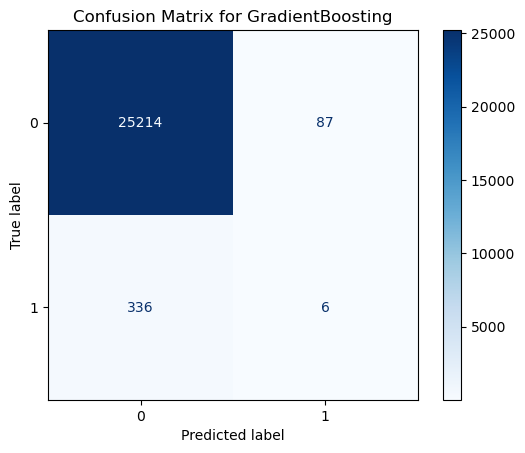

Generating Lift plot for GradientBoosting...



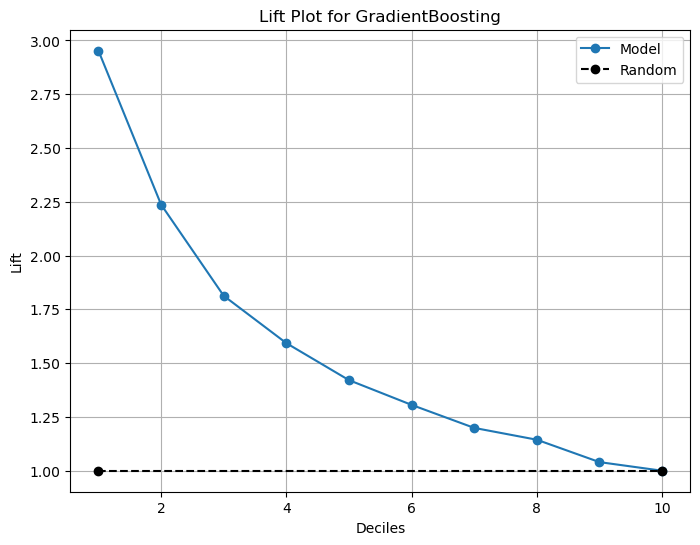

Generating Cumulative Gain plot for GradientBoosting...



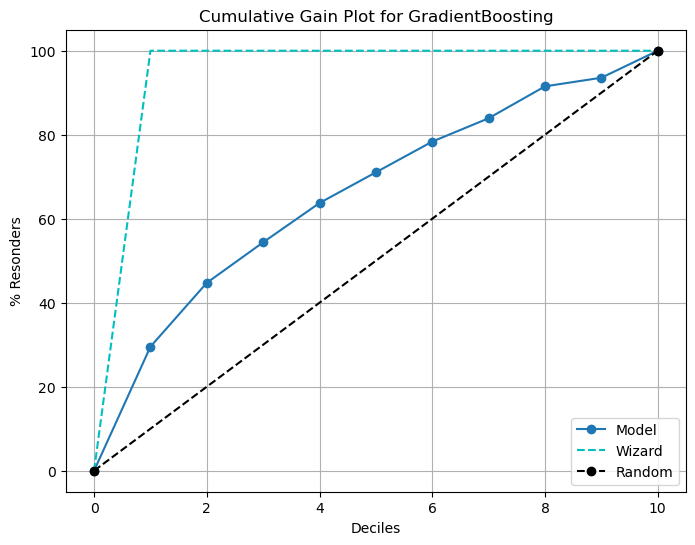

In [262]:
import matplotlib.pyplot as plt
import kds.metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Models to evaluate
model_classes = {
    "GradientBoosting": GradientBoostingClassifier
}

# Helper function to remove pipeline prefixes from parameters
def clean_params(params, prefix="classifier__"):
    return {k.replace(prefix, ""): v for k, v in params.items() if k.startswith(prefix)}

# Loop through results and evaluate models
for model_name, result in results.items():
    if model_name in model_classes.keys():
        print(f"\nEvaluating {model_name} on the Test Set...\n")

        # Retrieve the best hyperparameters and selected features
        best_params = result["best_params"]
        cleaned_params = clean_params(best_params)  # Remove pipeline prefixes
        selected_features = result["selected_features"]

        # Filter the test set using selected features
        X_test_selected = X_test[selected_features]

        # Rebuild the model with the cleaned parameters
        model_class = model_classes[model_name]
        best_model = model_class(**cleaned_params)

        # Refit the model on the entire training set (for final evaluation)
        X_train_selected = X_train[selected_features]
        best_model.fit(X_train_selected, y_train)

        # Predict probabilities for the positive class on the test set
        y_test_pred_prob = best_model.predict_proba(X_test_selected)[:, 1]

        # Calculate AUC score
        test_auc = roc_auc_score(y_test, y_test_pred_prob)
        print(f"Test AUC for {model_name}: {test_auc}")

        # Generate confusion matrix
        y_test_pred_class = best_model.predict(X_test_selected)
        cm = confusion_matrix(y_test, y_test_pred_class)
        print(f"Confusion Matrix for {model_name}:\n{cm}")

        # Display classification report
        print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_test_pred_class)}")

        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()

        # LIFT PLOT
        print(f"Generating Lift plot for {model_name}...\n")

        # Prepare the dataset for plotting Lift curve
        testset = testset.copy()
        testset["churn"] = y_test
        testset["proba churn"] = y_test_pred_prob

        # Plot Lift
        plt.figure(figsize=(8, 6))
        kds.metrics.plot_lift(testset["churn"], testset["proba churn"])
        plt.title(f"Lift Plot for {model_name}")
        plt.show()

        # CUMULATIVE GAIN PLOT
        print(f"Generating Cumulative Gain plot for {model_name}...\n")

        # Plot Cumulative Gain
        plt.figure(figsize=(8, 6))
        kds.metrics.plot_cumulative_gain(testset["churn"], testset["proba churn"])
        plt.title(f"Cumulative Gain Plot for {model_name}")
        plt.show()


In [463]:
donors_prob_test=testset[["donorID", "proba churn"]]

In [464]:
donors_prob_test = donors_prob_test.sort_values(by = 'proba churn')

In [465]:
tenpercent = int(len(donors_prob_test)*0.1)
low_10_percent_df = donors_prob_test.iloc[:tenpercent]

In [466]:
low_10_percent_df

,donorID,proba churn
1958,D104297,0.001310
15987,D129398,0.001357
1005,D102281,0.001359
21662,D137813,0.001359
2223,D104873,0.001359
...,...,...
23532,D140397,0.002583
21399,D137425,0.002583
24149,D141221,0.002583
22472,D139051,0.002583


In [467]:
low_10 = pd.merge(low_10_percent_df, donors, on='donorID', how='left')
low_10 = pd.merge(low_10, x_testset, on='donorID', how='left')

In [468]:
#below_cutoff.drop(columns=['zipcode_y', 'province_y', 'region_y', 'gender_y', 'language_y', 'dateOfBirth_y', 'Age_y'])

low_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   donorID                       2564 non-null   object        
 1   proba churn                   2564 non-null   float64       
 2   zipcode_x                     2564 non-null   float64       
 3   province_x                    2564 non-null   object        
 4   region                        2564 non-null   object        
 5   gender                        2563 non-null   object        
 6   language                      2564 non-null   object        
 7   dateOfBirth_x                 2564 non-null   datetime64[ns]
 8   Age_x                         2564 non-null   int64         
 9   campaignID                    2564 non-null   float64       
 10  amount                        2564 non-null   float64       
 11  dateOfDonation                

In [469]:
low_10['frequency'].describe()

count    2564.000000
mean        3.452808
std         6.739258
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       116.000000
Name: frequency, dtype: float64

In [470]:
low_10['Avg_donation'].describe()

count    2564.000000
mean       12.296596
std        12.120541
min         3.000000
25%         5.000000
50%        10.000000
75%        12.390000
max       276.463333
Name: Avg_donation, dtype: float64

In [471]:
gender_counts_low=low_10['gender'].value_counts()

In [472]:
gender_percentages = (gender_counts_low / len(low_10)) * 100

In [473]:
gender_percentages

gender
M    87.090484
F    12.870515
Name: count, dtype: float64

In [474]:
language_counts_low=low_10['language'].value_counts()

In [475]:
language_percentages = (language_counts_low / len(low_10)) * 100
language_percentages

language
NL    87.636505
FR    12.363495
Name: count, dtype: float64

In [476]:
region_counts_low=low_10['region'].value_counts()

In [477]:
region_percentages = (region_counts_low / len(low_10)) * 100
region_percentages

region
Flanders    87.597504
Wallonia     8.073323
Brussels     4.329173
Name: count, dtype: float64

In [478]:
top_10_percent_df = donors_prob_test.iloc[-tenpercent:]

In [479]:
top_10_percent_df.describe()

,proba churn
count,2564.000000
mean,0.079529
std,0.148303
min,0.015437
25%,0.020389
50%,0.028737
75%,0.056552
max,0.996778


In [480]:
top_10 = pd.merge(top_10_percent_df, donors, on='donorID', how='left')
top_10 = pd.merge(top_10, x_testset, on='donorID', how='left')

In [481]:
top_10['frequency'].describe()

count    2564.000000
mean        4.306552
std         8.219697
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       164.000000
Name: frequency, dtype: float64

In [482]:
top_10['Avg_donation'].describe()

count    2.564000e+03
mean     1.020735e+03
std      4.895634e+04
min      1.921294e+00
25%      2.066479e+01
50%      3.900000e+01
75%      4.606250e+01
max      2.479000e+06
Name: Avg_donation, dtype: float64

In [483]:
gender_counts_top=top_10['gender'].value_counts()

In [484]:
gender_percentages_top = (gender_counts_top / len(top_10)) * 100
gender_percentages_top

gender
F    57.878315
M    42.043682
Name: count, dtype: float64

In [485]:
language_counts_top=top_10['language'].value_counts()

In [486]:
language_percentages_top = (language_counts_top / len(top_10)) * 100
language_percentages_top

language
NL    89.664587
FR    10.335413
Name: count, dtype: float64

In [487]:
region_counts_top=top_10['region'].value_counts()

In [488]:
region_percentages_top = (region_counts_top / len(top_10)) * 100
print(type(region_percentages_top))

<class 'pandas.core.series.Series'>


In [489]:
comparison_gender = pd.DataFrame({
    'Top 10%': gender_percentages_top,
    'Low 10%': gender_percentages
})

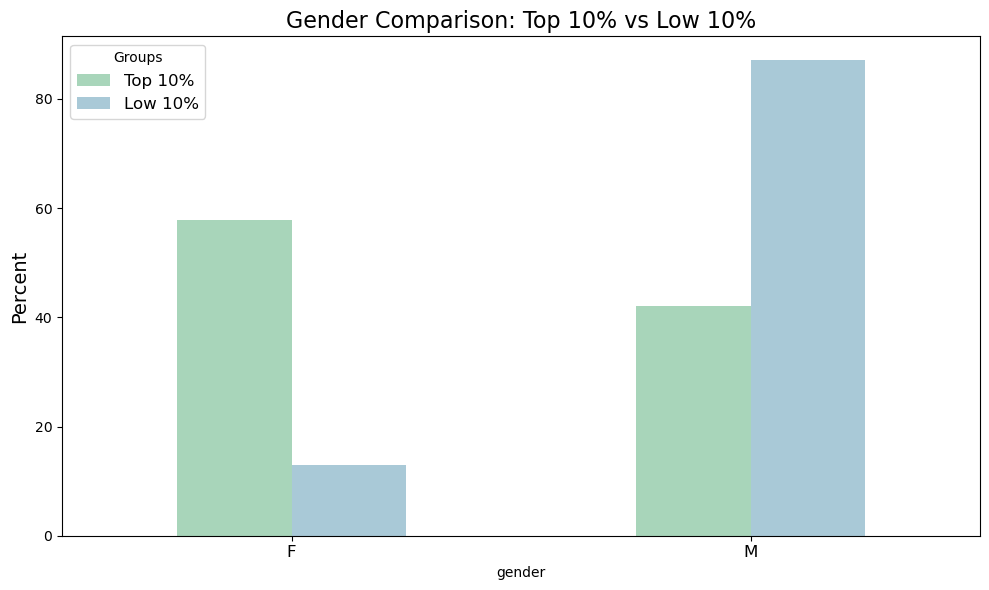

In [490]:
# Create a grouped bar chart
comparison_gender.plot(kind='bar', figsize=(10, 6), color=['#A8D5BA', '#A9C9D7'])

# Add titles and labels
plt.title('Gender Comparison: Top 10% vs Low 10%', fontsize=16)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Groups', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [491]:
comparison_language = pd.DataFrame({
    'Top 10%': language_percentages_top,
    'Low 10%': language_percentages
})

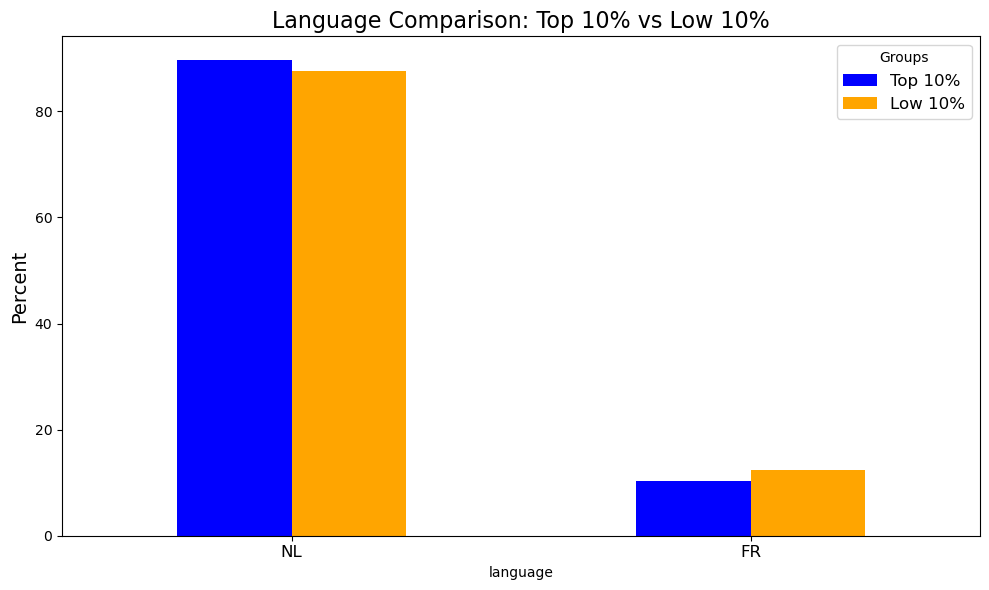

In [492]:
# Create a grouped bar chart
comparison_language.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])

# Add titles and labels
plt.title('Language Comparison: Top 10% vs Low 10%', fontsize=16)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Groups', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [493]:
comparison_region = pd.DataFrame({
    'Top 10%': region_percentages_top,
    'Low 10%': region_percentages
})

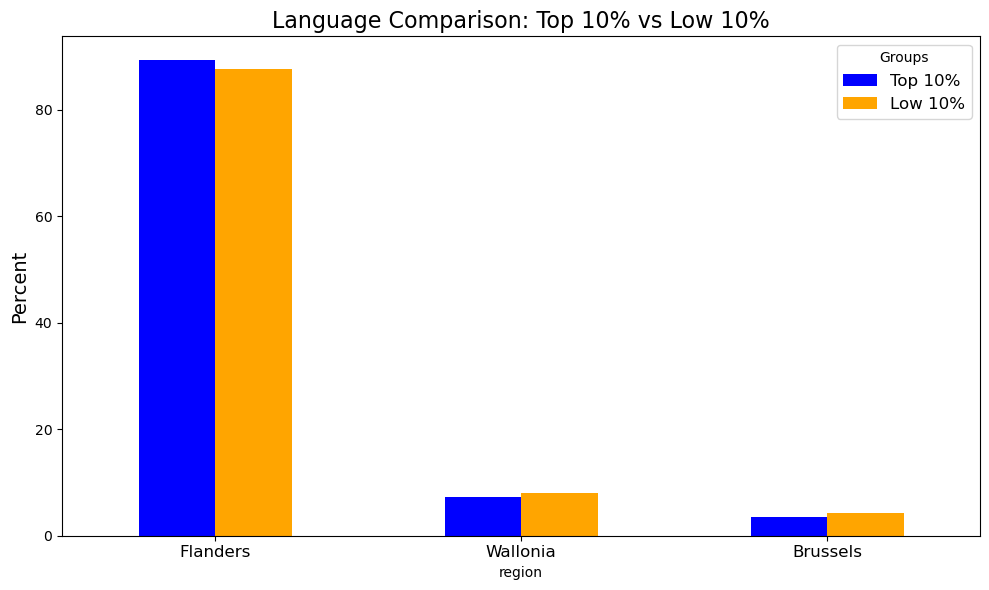

In [494]:
# Create a grouped bar chart
comparison_region.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])

# Add titles and labels
plt.title('Language Comparison: Top 10% vs Low 10%', fontsize=16)
plt.ylabel('Percent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Groups', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [495]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   donorID                       34868 non-null  object 
 1   campaignID                    34868 non-null  float64
 2   amount_x                      34868 non-null  float64
 3   Age                           34868 non-null  int64  
 4   frequency                     34868 non-null  int64  
 5   monetary_value                34868 non-null  float64
 6   recency                       34868 non-null  int64  
 7   Avg_donation                  34868 non-null  float64
 8   fl_region_is_Flanders         34868 non-null  bool   
 9   fl_region_is_Wallonia         34868 non-null  bool   
 10  fl_gender_is_M                34868 non-null  bool   
 11  fl_language_is_EN             34868 non-null  bool   
 12  fl_language_is_FR             34868 non-null  bool   
 13  f

Campaign7662

In [496]:
campaign_7662 = pd.read_csv(r'C:\Users\lvargas\Desktop\1 semestre\Predictive\Data\selection campaign 7662.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lvargas\\Desktop\\1 semestre\\Predictive\\Data\\selection campaign 7662.csv'

In [1054]:
#Validation set 
validationset= pd.merge(gifts,campaign_7662, on='donorID')
validationset= pd.merge(validationset, donors, on='donorID')
validationset=pd.merge(validationset,campaigns,on='campaignID', how='left' )

In [1055]:
validationset

,donorID,campaignID,amount,date_x,zipcode,province,region,gender,language,dateOfBirth,date_y,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,NaN,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,09/10/2007,34 636,"0,31 €"
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,08/12/2007,34 080,"0,21 €"
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,25/05/2008,30 558,"0,41 €"
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,22/06/2008,39 664,"0,61 €"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129694,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,08/06/2018,39 445,"0,30 €"
129695,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,26/04/2019,28 592,"0,06 €"
129696,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,26/11/2019,35 199,"0,36 €"
129697,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,05/07/1976,25/12/2014,37 833,"0,50 €"


In [1056]:
# dates for validation
campaign_date = pd.Timestamp("2020-02-01")

# (training)
#start_x_training = campaign_date - pd.DateOffset(years=3)  
end_x_validation = campaign_date- pd.DateOffset(days=30) 
#print(f"x_Training: {start_x_training} to {end_x_training}")

In [1057]:
x_validationset = validationset[
     (validationset['date_x'] <= end_x_validation) 
]

In [1058]:
#Rename columns
x_validationset = x_validationset.rename(columns={'date_x':'dateOfDonation'})
x_validationset = x_validationset.rename(columns={'date_y':'dateOfCampaign'})

x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,dateOfCampaign,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,NaN,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,09/10/2007,34 636,"0,31 €"
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,08/12/2007,34 080,"0,21 €"
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,25/05/2008,30 558,"0,41 €"
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,22/06/2008,39 664,"0,61 €"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129694,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,08/06/2018,39 445,"0,30 €"
129695,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,26/04/2019,28 592,"0,06 €"
129696,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,26/11/2019,35 199,"0,36 €"
129697,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,05/07/1976,25/12/2014,37 833,"0,50 €"


In [1059]:
print(x_validationset.isnull().sum())

donorID              0
campaignID           0
amount              23
dateOfDonation       0
zipcode             13
province             0
region               0
gender             138
language             0
dateOfBirth          0
dateOfCampaign    9073
lettersSent       9073
CostUnit          9073
dtype: int64


In [1060]:
#Frequency 

x_validationset_freq= x_validationset[x_validationset['dateOfDonation'].notnull()]

x_validationset_freq = x_validationset.groupby('donorID').size().reset_index(name='frequency')

x_validationset_freq.head()

,donorID,frequency
0,D100001,12
1,D100003,12
2,D100004,26
3,D100006,1
4,D100009,19


In [1061]:
#add frequency to table 
x_validationset=pd.merge(x_validationset,x_validationset_freq,on='donorID' )

In [1062]:
x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,region,gender,language,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,frequency
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,NaN,NaN,NaN,12
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,09/10/2007,34 636,"0,31 €",12
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,08/12/2007,34 080,"0,21 €",12
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,25/05/2008,30 558,"0,41 €",12
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967,22/06/2008,39 664,"0,61 €",12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129692,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,08/06/2018,39 445,"0,30 €",4
129693,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,26/04/2019,28 592,"0,06 €",4
129694,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,Flanders,M,NL,04/21/1967,26/11/2019,35 199,"0,36 €",4
129695,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,Flanders,M,FR,05/07/1976,25/12/2014,37 833,"0,50 €",1


In [1063]:
#monetary 
monetary = x_validationset.groupby('donorID')['amount'].sum().reset_index()
monetary.rename(columns={'amount': 'monetary_value'}, inplace=True)
x_validationset = pd.merge(x_validationset, monetary, on='donorID')

In [1064]:
#recency 
analysis_date = pd.to_datetime('2020-02-01')

x_validationset['recency'] = (analysis_date - x_validationset['dateOfDonation']).dt.days

In [1065]:
#avg donation 
x_validationset['Avg_donation']=x_validationset.groupby('donorID')['amount'].transform('mean')

In [1066]:
#replace missing values in region with the mode 

gender_mode = x_validationset["region"].mode()[0]

# fill in 
x_validationset['region'] = x_validationset["region"].replace('Missing', gender_mode)

print(x_validationset['region'].value_counts())

region
Flanders    122381
Wallonia      4354
Brussels      2962
Name: count, dtype: int64


In [1067]:
#region dummys 
x_validationset = x_validationset.join(pd.get_dummies(x_validationset["region"], prefix = "fl_region_is", drop_first = 1))
x_validationset = x_validationset.drop(columns=["region"])

In [1068]:
#replace missing values in gender with the mode 

gender_mode =x_validationset["gender"].mode()[0]

# fill in 
x_validationset["gender"].fillna(gender_mode)

0         F
1         F
2         F
3         F
4         F
         ..
129692    M
129693    M
129694    M
129695    M
129696    M
Name: gender, Length: 129697, dtype: object

In [1069]:
#gender
x_validationset= x_validationset.join(pd.get_dummies(x_validationset["gender"], prefix = "fl_gender_is", drop_first = 1))
x_validationset =x_validationset.drop(columns=["gender"])


In [1070]:
#replace missing values in gender with the mode 

leng_mode = x_validationset["language"].mode()[0]

# fill in 
x_validationset["language"].fillna(leng_mode)

0         NL
1         NL
2         NL
3         NL
4         NL
          ..
129692    NL
129693    NL
129694    NL
129695    FR
129696    FR
Name: language, Length: 129697, dtype: object

In [1071]:
#lenguage 
x_validationset = x_validationset.join(pd.get_dummies(x_validationset["language"], prefix = "fl_language_is"))
x_validationset = x_validationset.drop(columns=["language"])

In [1072]:
#total donations 
donation_counts = x_validationset.groupby('donorID')['amount'].count()


x_validationset['total_donations'] = x_validationset['donorID'].map(donation_counts)

In [1073]:
x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,...,monetary_value,recency,Avg_donation,fl_region_is_Flanders,fl_region_is_Wallonia,fl_gender_is_M,fl_language_is_EN,fl_language_is_FR,fl_language_is_NL,total_donations
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,12/24/1967,NaN,NaN,NaN,...,178.49,5793,14.874167,True,False,False,False,False,True,12
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,12/24/1967,09/10/2007,34 636,"0,31 €",...,178.49,4496,14.874167,True,False,False,False,False,True,12
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,12/24/1967,08/12/2007,34 080,"0,21 €",...,178.49,4418,14.874167,True,False,False,False,False,True,12
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,12/24/1967,25/05/2008,30 558,"0,41 €",...,178.49,4249,14.874167,True,False,False,False,False,True,12
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,12/24/1967,22/06/2008,39 664,"0,61 €",...,178.49,4224,14.874167,True,False,False,False,False,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129692,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,04/21/1967,08/06/2018,39 445,"0,30 €",...,424.79,586,106.197500,True,False,True,False,False,True,4
129693,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,04/21/1967,26/04/2019,28 592,"0,06 €",...,424.79,276,106.197500,True,False,True,False,False,True,4
129694,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,04/21/1967,26/11/2019,35 199,"0,36 €",...,424.79,57,106.197500,True,False,True,False,False,True,4
129695,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,05/07/1976,25/12/2014,37 833,"0,50 €",...,40.00,1859,40.000000,True,False,True,False,True,False,1


In [1074]:
max_donations=x_validationset.groupby('donorID')['amount'].max()
x_validationset['max_donations'] = x_validationset['donorID'].map(max_donations)

In [1075]:
#min 
min_donations=x_validationset.groupby('donorID')['amount'].min()
x_validationset['min_donations'] = x_validationset['donorID'].map(min_donations)

In [1076]:
#replace missing values in gender with the mode 

birth_mode = x_validationset["dateOfBirth"].mode()[0]

# fill in 
x_validationset["dateOfBirth"].fillna(pd.Timestamp('2020-02-01'))

0         12/24/1967
1         12/24/1967
2         12/24/1967
3         12/24/1967
4         12/24/1967
             ...    
129692    04/21/1967
129693    04/21/1967
129694    04/21/1967
129695    05/07/1976
129696    06/05/1987
Name: dateOfBirth, Length: 129697, dtype: object

In [1077]:
#Age
x_validationset['dateOfBirth'] = pd.to_datetime(x_validationset['dateOfBirth'])

# Define the reference date (current date)
current_date = pd.to_datetime('2020-02-01')

# Calculate age
x_validationset['Age'] = x_validationset['dateOfBirth'].apply(lambda dob: current_date.year - dob.year - ((current_date.month, current_date.day) < (dob.month, dob.day)))

In [1078]:
#replace missing values in gender with the mode 

age_mode = x_validationset["Age"].mode()[0]

# fill in 
x_validationset["Age"].fillna(age_mode)

0         52
1         52
2         52
3         52
4         52
          ..
129692    52
129693    52
129694    52
129695    43
129696    32
Name: Age, Length: 129697, dtype: int64

In [1079]:
x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,...,fl_region_is_Flanders,fl_region_is_Wallonia,fl_gender_is_M,fl_language_is_EN,fl_language_is_FR,fl_language_is_NL,total_donations,max_donations,min_donations,Age
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,NaN,NaN,NaN,...,True,False,False,False,False,True,12,30.0,6.69,52
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,09/10/2007,34 636,"0,31 €",...,True,False,False,False,False,True,12,30.0,6.69,52
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,08/12/2007,34 080,"0,21 €",...,True,False,False,False,False,True,12,30.0,6.69,52
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,25/05/2008,30 558,"0,41 €",...,True,False,False,False,False,True,12,30.0,6.69,52
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,22/06/2008,39 664,"0,61 €",...,True,False,False,False,False,True,12,30.0,6.69,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129692,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,08/06/2018,39 445,"0,30 €",...,True,False,True,False,False,True,4,200.0,24.79,52
129693,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,1967-04-21,26/04/2019,28 592,"0,06 €",...,True,False,True,False,False,True,4,200.0,24.79,52
129694,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,1967-04-21,26/11/2019,35 199,"0,36 €",...,True,False,True,False,False,True,4,200.0,24.79,52
129695,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,25/12/2014,37 833,"0,50 €",...,True,False,True,False,True,False,1,40.0,40.00,43


In [1080]:
#day of donation vs day of campaing 
x_validationset['dateOfCampaign']=pd.to_datetime(x_validationset['dateOfCampaign'],format='%d/%m/%Y', errors='coerce')

In [1081]:
#calculate the days between the campign and the day of the donation 
x_validationset['DaysDiff'] = (x_validationset['dateOfDonation'] - x_validationset['dateOfCampaign']).dt.days

In [1082]:
#avg of daysdiff

avg_daysdiff = x_validationset.groupby('donorID')['DaysDiff'].mean()

x_validationset['avg_daysdiff'] = x_validationset['donorID'].map(round(avg_daysdiff, 2))

In [1083]:
# Calculate time difference (in days) between consecutive donations for each DonorID
x_validationset['TimeDiff'] = x_validationset.groupby('donorID')['dateOfDonation'].diff().dt.days

In [1084]:
#avg of timediff

avg_timediff = x_validationset.groupby('donorID')['TimeDiff'].mean()

x_validationset['avg_timediff'] = x_validationset['donorID'].map(avg_timediff)

In [1085]:
global_median_timediff = x_validationset['TimeDiff'].median()

x_validationset['avg_timediff'] = x_validationset['avg_timediff'].fillna(global_median_timediff)

In [1086]:
#Interaction Effect Variable between age and gender

x_validationset['age_fl_gender_is'] = x_validationset['Age'] * x_validationset['fl_gender_is_M']

In [1087]:
#Interaction Effect between age and region

x_validationset['age_fl_region_is_Flanders'] = x_validationset['Age'] * x_validationset['fl_region_is_Flanders']
x_validationset['age_fl_region_is_Wallonia'] = x_validationset['Age'] * x_validationset['fl_region_is_Wallonia']
#no more other regions?

In [1088]:
#Interaction Effect between age and language

x_validationset['age_fl_language_is_FR'] = x_validationset['Age'] * x_validationset['fl_language_is_FR']
x_validationset['age_fl_language_is_NL'] = x_validationset['Age'] * x_validationset['fl_language_is_NL']

In [1089]:
#Interaction Effect between Gender and Region

x_validationset['gender_fl_region_is_Flanders'] = x_validationset['fl_gender_is_M'] * x_validationset['fl_region_is_Flanders']
x_validationset['gender_fl_region_is_Wallonia'] = x_validationset['fl_gender_is_M'] * x_validationset['fl_region_is_Wallonia']

In [1090]:
#Interaction Effect between Gender and Language

x_validationset['gender_fl_language_is_FR'] = x_validationset['fl_gender_is_M'] * x_validationset['fl_language_is_FR']
x_validationset['gender_fl_language_is_NL'] = x_validationset['fl_gender_is_M'] * x_validationset['fl_language_is_NL']

In [1091]:
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
x_validationset['age_group'] = pd.cut(x_validationset['Age'], bins=bins, labels=labels)
x_validationset = pd.get_dummies(x_validationset, columns=['age_group'], prefix=['age_group'])

In [1092]:
lifespan = x_validationset.groupby('donorID')['dateOfDonation'].agg(['min', 'max'])
x_validationset['lifespan_days'] = x_validationset['donorID'].map(
    (lifespan['max'] - lifespan['min']).dt.days
)

In [1093]:
x_validationset['donation_rank'] = x_validationset.groupby('donorID')['dateOfDonation'].rank()
early_avg = (
    x_validationset[x_validationset['donation_rank'] <= 3]
    .groupby('donorID')['amount']
    .mean()
)
recent_avg = (
    x_validationset[x_validationset['donation_rank'] > (x_validationset['donation_rank'].max() - 3)]
    .groupby('donorID')['amount']
    .mean()
)
x_validationset['donation_trend'] = x_validationset['donorID'].map(
    recent_avg / early_avg
)

In [1094]:
donation_variability = x_validationset.groupby('donorID')['amount'].std()
x_validationset['donation_variability'] = x_validationset['donorID'].map(donation_variability)

In [1095]:
x_validationset['days_between'] = x_validationset.groupby('donorID')['dateOfDonation'].diff().dt.days
donation_density = x_validationset.groupby('donorID')['days_between'].mean()
x_validationset['donation_density'] = x_validationset['donorID'].map(donation_density)

In [1096]:
campaign_engagement = x_validationset.groupby('donorID')['campaignID'].nunique()
x_validationset['campaign_engagement'] = x_validationset['donorID'].map(campaign_engagement)

In [1097]:
recent_donations = x_validationset[x_validationset['dateOfDonation'] >= (end_x_validation - pd.DateOffset(years=1))]
recent_ratio = recent_donations.groupby('donorID')['amount'].count() / x_validationset.groupby('donorID')['amount'].count()
x_validationset['recent_donations_ratio'] = x_validationset['donorID'].map(recent_ratio)

In [1098]:
max_donation = x_validationset.groupby('donorID')['amount'].max()
x_validationset['max_donation'] = x_validationset['donorID'].map(max_donation)

In [1099]:
donor_loyalty = x_validationset.groupby('donorID')['campaignID'].nunique() / x_validationset['campaignID'].nunique()
x_validationset['donor_loyalty'] = x_validationset['donorID'].map(donor_loyalty)

In [1100]:
x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,NaT,NaN,NaN,...,2838,1.0,NaN,7.870151,NaN,258.0,12,NaN,30.0,0.033426
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,2007-10-09,34 636,"0,31 €",...,2838,2.0,NaN,7.870151,1297.0,258.0,12,NaN,30.0,0.033426
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,2007-12-08,34 080,"0,21 €",...,2838,3.0,NaN,7.870151,78.0,258.0,12,NaN,30.0,0.033426
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,2008-05-25,30 558,"0,41 €",...,2838,4.0,NaN,7.870151,169.0,258.0,12,NaN,30.0,0.033426
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,2008-06-22,39 664,"0,61 €",...,2838,5.0,NaN,7.870151,25.0,258.0,12,NaN,30.0,0.033426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129692,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,2018-06-08,39 445,"0,30 €",...,5250,2.0,NaN,71.886271,4721.0,1750.0,4,0.5,200.0,0.011142
129693,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,1967-04-21,2019-04-26,28 592,"0,06 €",...,5250,3.0,NaN,71.886271,310.0,1750.0,4,0.5,200.0,0.011142
129694,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,1967-04-21,2019-11-26,35 199,"0,36 €",...,5250,4.0,NaN,71.886271,219.0,1750.0,4,0.5,200.0,0.011142
129695,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,2014-12-25,37 833,"0,50 €",...,0,1.0,NaN,NaN,NaN,NaN,1,NaN,40.0,0.002786


In [1101]:
x_validationset.fillna(0, inplace=True)

C:\Users\lvargas\AppData\Local\Temp\ipykernel_15524\2363812659.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  x_validationset.fillna(0, inplace=True)


In [1102]:
x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,0,0,0,...,2838,1.0,0.0,7.870151,0.0,258.0,12,0.0,30.0,0.033426
1,D100001,1577.0,12.39,2007-10-11,1861.0,Flemish Brabant,1967-12-24,2007-10-09 00:00:00,34 636,"0,31 €",...,2838,2.0,0.0,7.870151,1297.0,258.0,12,0.0,30.0,0.033426
2,D100001,1634.0,6.69,2007-12-28,1861.0,Flemish Brabant,1967-12-24,2007-12-08 00:00:00,34 080,"0,21 €",...,2838,3.0,0.0,7.870151,78.0,258.0,12,0.0,30.0,0.033426
3,D100001,1778.0,24.79,2008-06-14,1861.0,Flemish Brabant,1967-12-24,2008-05-25 00:00:00,30 558,"0,41 €",...,2838,4.0,0.0,7.870151,169.0,258.0,12,0.0,30.0,0.033426
4,D100001,1808.0,7.44,2008-07-09,1861.0,Flemish Brabant,1967-12-24,2008-06-22 00:00:00,39 664,"0,61 €",...,2838,5.0,0.0,7.870151,25.0,258.0,12,0.0,30.0,0.033426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129692,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,2018-06-08 00:00:00,39 445,"0,30 €",...,5250,2.0,0.0,71.886271,4721.0,1750.0,4,0.5,200.0,0.011142
129693,D144689,7212.0,100.00,2019-05-01,3061.0,Flemish Brabant,1967-04-21,2019-04-26 00:00:00,28 592,"0,06 €",...,5250,3.0,0.0,71.886271,310.0,1750.0,4,0.5,200.0,0.011142
129694,D144689,7519.0,200.00,2019-12-06,3061.0,Flemish Brabant,1967-04-21,2019-11-26 00:00:00,35 199,"0,36 €",...,5250,4.0,0.0,71.886271,219.0,1750.0,4,0.5,200.0,0.011142
129695,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,2014-12-25 00:00:00,37 833,"0,50 €",...,0,1.0,0.0,0.000000,0.0,0.0,1,0.0,40.0,0.002786


In [1103]:
x_validationset=x_validationset.sort_values(by=['donorID'],ascending=[True])

x_validationset=x_validationset.drop_duplicates(subset= 'donorID', keep='first')

In [1104]:
x_validationset

,donorID,campaignID,amount,dateOfDonation,zipcode,province,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,...,lifespan_days,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,0,0,0,...,2838,1.0,0.0,7.870151,0.0,258.000000,12,0.000000,30.00,0.033426
20,D100003,7074.0,4.00,2019-03-08,1780.0,Flemish Brabant,1986-12-23,2019-03-05 00:00:00,20 305,"0,04 €",...,690,9.0,0.0,0.577350,43.0,62.727273,12,0.416667,5.00,0.033426
38,D100004,1790.0,24.79,2008-06-24,1020.0,Brussels,1952-03-29,2008-06-04 00:00:00,35 199,"0,50 €",...,2162,15.0,0.0,5.142858,160.0,86.480000,26,0.000000,49.58,0.072423
50,D100006,4830.0,5.00,2017-08-15,1090.0,Brussels,1926-06-01,2017-08-09 00:00:00,28 955,"0,19 €",...,0,1.0,0.0,0.000000,0.0,0.000000,1,0.000000,5.00,0.002786
69,D100009,3125.0,20.00,2012-03-25,1020.0,Brussels,1932-01-20,2012-03-08 00:00:00,31 665,"0,30 €",...,2259,19.0,0.0,5.682107,95.0,125.500000,19,0.000000,25.00,0.052925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129683,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,2015-10-18 00:00:00,24 753,"0,20 €",...,0,1.0,0.0,0.000000,0.0,0.000000,1,0.000000,10.00,0.002786
129689,D144688,2802.0,5.00,2011-06-26,3600.0,Limburg,1972-11-28,2011-06-15 00:00:00,47 875,"0,31 €",...,3429,6.0,0.0,3.946094,983.0,571.500000,7,0.000000,15.00,0.019499
129692,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,2018-06-08 00:00:00,39 445,"0,30 €",...,5250,2.0,0.0,71.886271,4721.0,1750.000000,4,0.500000,200.00,0.011142
129695,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,2014-12-25 00:00:00,37 833,"0,50 €",...,0,1.0,0.0,0.000000,0.0,0.000000,1,0.000000,40.00,0.002786


In [1105]:
#timeframe
start_y_validation = campaign_date + pd.Timedelta(days=1)  # one day after the campaigne 
end_y_validation = campaign_date + pd.Timedelta(days=30) 

# print(f"x_Training: {start_test} to {end_test}")
print(f"y_Training: {start_y_validation} to {end_y_validation}")

y_Training: 2020-02-02 00:00:00 to 2020-03-02 00:00:00


In [1106]:
y_validation=pd.merge(gifts, campaign_7662, on='donorID')

In [1107]:
y_validation = y_validation[
    (y_validation['date'] >= start_y_test) &  
    (y_validation['date'] <= end_y_test) 
]

In [1108]:
y_validation

,donorID,campaignID,amount,date
2904,D100607,0.0,4.0,2019-06-27
3571,D100724,7244.0,40.0,2019-07-04
4049,D100834,7243.0,5.0,2019-06-21
4458,D100884,7243.0,40.0,2019-06-20
4558,D100896,7244.0,10.0,2019-06-28
...,...,...,...,...
128580,D144369,7244.0,6.0,2019-07-01
128595,D144371,7244.0,100.0,2019-07-02
129189,D144481,7244.0,80.0,2019-06-23
129290,D144512,7244.0,20.0,2019-07-07


In [1109]:
y_validation = y_validation.groupby('donorID')['amount'].sum().reset_index()

y_validation

,donorID,amount
0,D100607,4.0
1,D100724,40.0
2,D100834,5.0
3,D100884,40.0
4,D100896,10.0
...,...,...
460,D144369,6.0
461,D144371,100.0
462,D144481,80.0
463,D144512,20.0


In [1110]:
y_validation['target'] = (y_validation['amount'] >= 10).astype(int)
y_validation

,donorID,amount,target
0,D100607,4.0,0
1,D100724,40.0,1
2,D100834,5.0,0
3,D100884,40.0,1
4,D100896,10.0,1
...,...,...,...
460,D144369,6.0,0
461,D144371,100.0,1
462,D144481,80.0,1
463,D144512,20.0,1


In [1111]:
#final basetable for test with features and target 

validationset=pd.merge(x_validationset,y_validation,on='donorID' , how='left')

In [1112]:
validationset

,donorID,campaignID,amount_x,dateOfDonation,zipcode,province,dateOfBirth,dateOfCampaign,lettersSent,CostUnit,...,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty,amount_y,target
0,D100001,0.0,12.39,2004-03-23,1861.0,Flemish Brabant,1967-12-24,0,0,0,...,0.0,7.870151,0.0,258.000000,12,0.000000,30.00,0.033426,NaN,NaN
1,D100003,7074.0,4.00,2019-03-08,1780.0,Flemish Brabant,1986-12-23,2019-03-05 00:00:00,20 305,"0,04 €",...,0.0,0.577350,43.0,62.727273,12,0.416667,5.00,0.033426,NaN,NaN
2,D100004,1790.0,24.79,2008-06-24,1020.0,Brussels,1952-03-29,2008-06-04 00:00:00,35 199,"0,50 €",...,0.0,5.142858,160.0,86.480000,26,0.000000,49.58,0.072423,NaN,NaN
3,D100006,4830.0,5.00,2017-08-15,1090.0,Brussels,1926-06-01,2017-08-09 00:00:00,28 955,"0,19 €",...,0.0,0.000000,0.0,0.000000,1,0.000000,5.00,0.002786,NaN,NaN
4,D100009,3125.0,20.00,2012-03-25,1020.0,Brussels,1932-01-20,2012-03-08 00:00:00,31 665,"0,30 €",...,0.0,5.682107,95.0,125.500000,19,0.000000,25.00,0.052925,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26503,D144687,4210.0,10.00,2015-11-06,4900.0,Liege,1970-09-12,2015-10-18 00:00:00,24 753,"0,20 €",...,0.0,0.000000,0.0,0.000000,1,0.000000,10.00,0.002786,NaN,NaN
26504,D144688,2802.0,5.00,2011-06-26,3600.0,Limburg,1972-11-28,2011-06-15 00:00:00,47 875,"0,31 €",...,0.0,3.946094,983.0,571.500000,7,0.000000,15.00,0.019499,NaN,NaN
26505,D144689,5326.0,100.00,2018-06-25,3061.0,Flemish Brabant,1967-04-21,2018-06-08 00:00:00,39 445,"0,30 €",...,0.0,71.886271,4721.0,1750.000000,4,0.500000,200.00,0.011142,NaN,NaN
26506,D144690,3941.0,40.00,2014-12-30,1950.0,Flemish Brabant,1976-05-07,2014-12-25 00:00:00,37 833,"0,50 €",...,0.0,0.000000,0.0,0.000000,1,0.000000,40.00,0.002786,NaN,NaN


In [1113]:
validationset['target'].value_counts(dropna=False)

target
NaN    26043
1.0      389
0.0       76
Name: count, dtype: int64

In [1114]:
validationset = validationset.drop(columns=[ 'amount_y','dateOfDonation','zipcode','province','dateOfBirth','dateOfCampaign','lettersSent','CostUnit','TimeDiff','avg_daysdiff','DaysDiff'])

In [1115]:
validationset = validationset.fillna(0)

In [1116]:
validationset['target'].value_counts(dropna=False)

target
0.0    26119
1.0      389
Name: count, dtype: int64

In [1117]:
print(validationset.isnull().sum())

donorID                         0
campaignID                      0
amount_x                        0
frequency                       0
monetary_value                  0
recency                         0
Avg_donation                    0
fl_region_is_Flanders           0
fl_region_is_Wallonia           0
fl_gender_is_M                  0
fl_language_is_EN               0
fl_language_is_FR               0
fl_language_is_NL               0
total_donations                 0
max_donations                   0
min_donations                   0
Age                             0
avg_timediff                    0
age_fl_gender_is                0
age_fl_region_is_Flanders       0
age_fl_region_is_Wallonia       0
age_fl_language_is_FR           0
age_fl_language_is_NL           0
gender_fl_region_is_Flanders    0
gender_fl_region_is_Wallonia    0
gender_fl_language_is_FR        0
gender_fl_language_is_NL        0
age_group_18-29                 0
age_group_30-39                 0
age_group_40-4

In [1118]:
validationset

,donorID,campaignID,amount_x,frequency,monetary_value,recency,Avg_donation,fl_region_is_Flanders,fl_region_is_Wallonia,fl_gender_is_M,...,donation_rank,donation_trend,donation_variability,days_between,donation_density,campaign_engagement,recent_donations_ratio,max_donation,donor_loyalty,target
0,D100001,0.0,12.39,12,178.49,5793,14.874167,True,False,False,...,1.0,0.0,7.870151,0.0,258.000000,12,0.000000,30.00,0.033426,0.0
1,D100003,7074.0,4.00,12,46.00,330,3.833333,True,False,True,...,9.0,0.0,0.577350,43.0,62.727273,12,0.416667,5.00,0.033426,0.0
2,D100004,1790.0,24.79,26,716.22,4239,27.546923,False,False,False,...,15.0,0.0,5.142858,160.0,86.480000,26,0.000000,49.58,0.072423,0.0
3,D100006,4830.0,5.00,1,5.00,900,5.000000,False,False,True,...,1.0,0.0,0.000000,0.0,0.000000,1,0.000000,5.00,0.002786,0.0
4,D100009,3125.0,20.00,19,326.78,2869,17.198947,False,False,True,...,19.0,0.0,5.682107,95.0,125.500000,19,0.000000,25.00,0.052925,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26503,D144687,4210.0,10.00,1,10.00,1548,10.000000,False,True,True,...,1.0,0.0,0.000000,0.0,0.000000,1,0.000000,10.00,0.002786,0.0
26504,D144688,2802.0,5.00,7,48.56,3142,6.937143,True,False,True,...,6.0,0.0,3.946094,983.0,571.500000,7,0.000000,15.00,0.019499,0.0
26505,D144689,5326.0,100.00,4,424.79,586,106.197500,True,False,True,...,2.0,0.0,71.886271,4721.0,1750.000000,4,0.500000,200.00,0.011142,0.0
26506,D144690,3941.0,40.00,1,40.00,1859,40.000000,True,False,True,...,1.0,0.0,0.000000,0.0,0.000000,1,0.000000,40.00,0.002786,0.0


In [ ]:
# Define a dictionary of algorithms and their hyperparameters
model_configs = {
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__n_estimators": [50, 100, 200],
        }
    },
}

# Dataset split
X_train = trainset.drop(columns=["target", "donorID", "campaignID"])
y_train =trainset["target"]

x_validation = validationset.drop(columns=["target", "donorID","campaignID"])
y_validation =validationset["target"]


# Standardize the data
scaler = StandardScaler()

# Feature selection
feature_selector = SequentialFeatureSelector(
    estimator=LogisticRegression(class_weight="balanced", random_state=42),
    direction="forward",
    scoring="roc_auc",
    cv=5,
)

# Iterate over all models
results = {}
for model_name, config in model_configs.items():
    print(f"Training {model_name}...")

    # Create a pipeline
    pipeline = Pipeline([
        ("scaler", scaler),
        ("feature_selector", feature_selector),
        ("classifier", config["model"]),
    ])

    # Randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=config["params"],
        n_iter=10,  # Number of random combinations to try
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1,
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best parameters and features
    best_model = random_search.best_estimator_
    selected_features = X_train.columns[best_model.named_steps["feature_selector"].get_support()]
    print(f"Best Parameters for {model_name}: {random_search.best_params_}")
    print(f"Selected Features for {model_name}: {selected_features.tolist()}")

    # Evaluate on the test set
    y_validation_pred_prob = best_model.predict_proba(x_validation)[:, 1]
    validation_auc = roc_auc_score(y_validation, y_validation_pred_prob)
    print(f"Validation AUC for {model_name}: {validation_auc}")

    # Store results
    results[model_name] = {
        "best_params": random_search.best_params_,
        "selected_features": selected_features.tolist(),
        "validation_auc": validation_auc,
    }

# Display final results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Selected Features: {result['selected_features']}")
    print(f"Validation AUC: {result['validation_auc']}")


Training GradientBoosting...


c:\Users\lvargas\.conda\envs\py\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for GradientBoosting: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.1}
Selected Features for GradientBoosting: ['amount_x', 'frequency', 'monetary_value', 'recency', 'Avg_donation', 'fl_region_is_Flanders', 'fl_gender_is_M', 'total_donations', 'max_donations', 'min_donations', 'Age', 'gender_fl_language_is_NL', 'age_group_18-29', 'age_group_50-59', 'lifespan_days', 'donation_rank', 'donation_variability', 'days_between', 'recent_donations_ratio', 'max_donation']
Validation AUC for GradientBoosting: 0.8346561628992712

GradientBoosting Results:
Best Parameters: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.1}
Selected Features: ['amount_x', 'frequency', 'monetary_value', 'recency', 'Avg_donation', 'fl_region_is_Flanders', 'fl_gender_is_M', 'total_donations', 'max_donations', 'min_donations', 'Age', 'gender_fl_language_is_NL', 'age_group_18-29', 'age_group_50-59', 'lifespan_days', 'donation_rank', 'donation_variability', 'days_between


Evaluating GradientBoosting on the Validation Set...

Validation AUC for GradientBoosting: 0.8364766816226031
Confusion Matrix for GradientBoosting:
[[25154   965]
 [  345    44]]
Classification Report for GradientBoosting:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     26119
         1.0       0.04      0.11      0.06       389

    accuracy                           0.95     26508
   macro avg       0.52      0.54      0.52     26508
weighted avg       0.97      0.95      0.96     26508



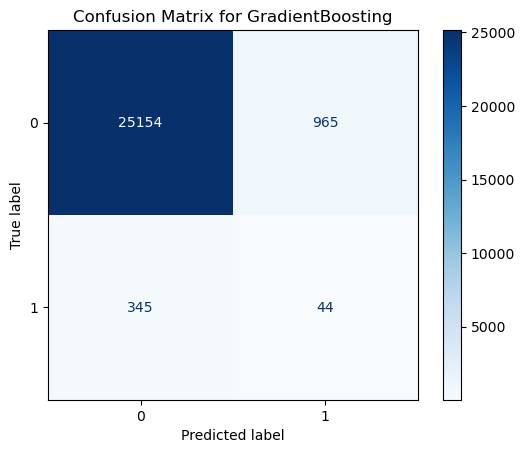

Generating Lift plot for GradientBoosting...



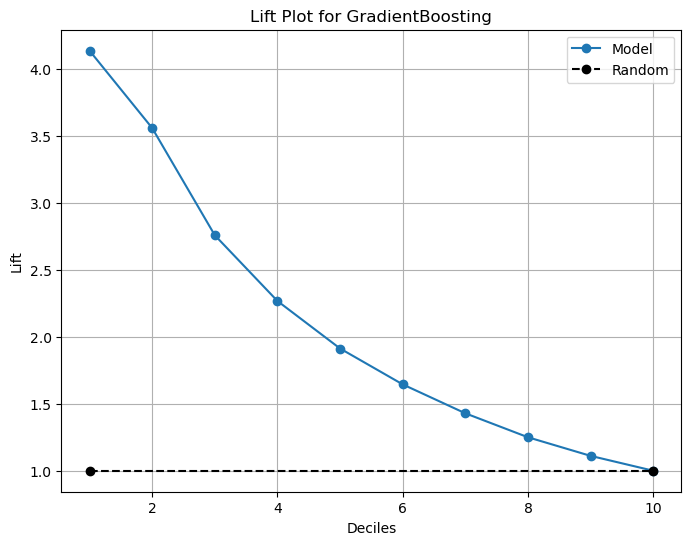

Generating Cumulative Gain plot for GradientBoosting...



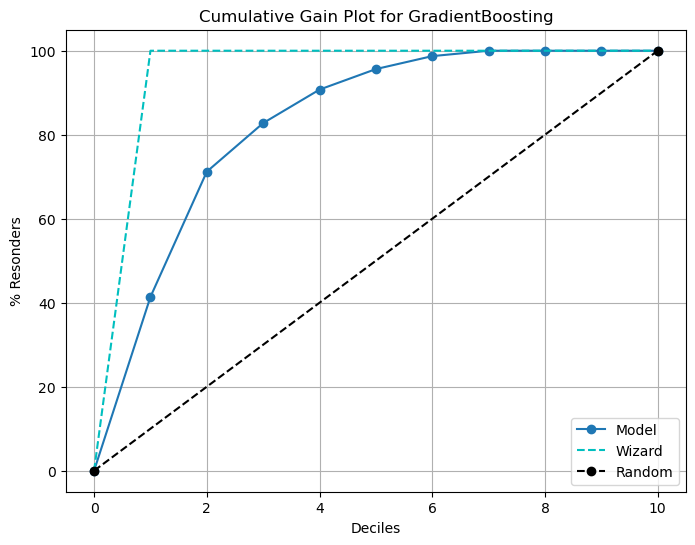

In [1127]:
import matplotlib.pyplot as plt
import kds.metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Models to evaluate
model_classes = {
    "GradientBoosting": GradientBoostingClassifier
}

# Helper function to remove pipeline prefixes from parameters
def clean_params(params, prefix="classifier__"):
    return {k.replace(prefix, ""): v for k, v in params.items() if k.startswith(prefix)}

# Loop through results and evaluate models
for model_name, result in results.items():
    if model_name in model_classes.keys():
        print(f"\nEvaluating {model_name} on the Validation Set...\n")

        # Retrieve the best hyperparameters and selected features
        best_params = result["best_params"]
        cleaned_params = clean_params(best_params)  # Remove pipeline prefixes
        selected_features = result["selected_features"]

        # Filter the test set using selected features
        X_validation_selected = x_validation[selected_features]

        # Rebuild the model with the cleaned parameters
        model_class = model_classes[model_name]
        best_model = model_class(**cleaned_params)

        # Refit the model on the entire training set (for final evaluation)
        X_train_selected = X_train[selected_features]
        best_model.fit(X_train_selected, y_train)

        # Predict probabilities for the positive class on the test set
        y_validation_pred_prob = best_model.predict_proba(X_validation_selected)[:, 1]

        # Calculate AUC score
        validation_auc = roc_auc_score(y_validation, y_validation_pred_prob)
        print(f"Validation AUC for {model_name}: {validation_auc}")

        # Generate confusion matrix
        y_validation_pred_class = best_model.predict(X_validation_selected)
        cm = confusion_matrix(y_validation, y_validation_pred_class)
        print(f"Confusion Matrix for {model_name}:\n{cm}")

        # Display classification report
        print(f"Classification Report for {model_name}:\n{classification_report(y_validation, y_validation_pred_class)}")

        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()

        # LIFT PLOT
        print(f"Generating Lift plot for {model_name}...\n")

        # Prepare the dataset for plotting Lift curve
        validationset = validationset.copy()
        validationset["churn"] = y_validation
        validationset["proba churn"] = y_validation_pred_prob

        # Plot Lift
        plt.figure(figsize=(8, 6))
        kds.metrics.plot_lift(validationset["churn"], validationset["proba churn"])
        plt.title(f"Lift Plot for {model_name}")
        plt.show()

        # CUMULATIVE GAIN PLOT
        print(f"Generating Cumulative Gain plot for {model_name}...\n")

        # Plot Cumulative Gain
        plt.figure(figsize=(8, 6))
        kds.metrics.plot_cumulative_gain(validationset["churn"], validationset["proba churn"])
        plt.title(f"Cumulative Gain Plot for {model_name}")
        plt.show()


In [1131]:
donors_prob=validationset[["donorID", "proba churn"]]

In [1133]:
donors_prob.to_csv(r'C:\Users\lvargas\Desktop\1 semestre\Predictive\donors_prob.csv', index=False)